# Kubernetes analysis

### a quick set-up

First of all let's define a couple of functions to make the code coming up simpler.
This uses `pymysql` a popular Python SQL connector, and numpy + matplotlib to show the
power and flexibility of the Engine.

In [2]:
# first some extra packages we're gonna need
!pip3 install matplotlib pymysql coloredlogs wordcloud

  Using cached https://files.pythonhosted.org/packages/ad/4c/0415f15f96864c3a2242b1c74041a806c100c1b21741206c5d87684437c6/matplotlib-3.0.2-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a7/7d/682c4a7da195a678047c8f1c51bb7682aaedee1dca7547883c3993ca9282/PyMySQL-0.9.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/08/0f/7877fc42fff0b9d70b6442df62d53b3868d3a6ad1b876bdb54335b30ff23/coloredlogs-10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5e/b7/c16286efa3d442d6983b3842f982502c00306c1a4c719c41fb00d6017c77/wordcloud-1.5.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/74/68/d87d9b36af36f44254a8d512cbfc48369103a3b9e474be9bdfe536abfc45/python_dateutil-2.7.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7e/31/d6fedd4fb2c94755cd101191e581af30e1650ccce7a35bddb7930fed6574/kiwisolver-1.0.1-cp35-cp35m-manylinux1_x86_64.whl
  U

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pymysql
import time
import coloredlogs, logging

# coloredlogs.install(level='DEBUG')
coloredlogs.install(level='INFO')

def run(query, log=True):
    conn = pymysql.connect(host='35.239.21.20', port=3306, user='root', passwd='sourced', db='mysql')
    start = time.time()

    cursor = conn.cursor()
    cursor.execute(query)

    end = time.time()
    if log:
        logging.info("done in %.2f seconds" % (end - start))
    return cursor

def run_one(query, log=True):
    return run(query, log).fetchone()

def run_and_print(query):
    for row in run(query):
        print(*row)

## Counting files

Let's start by seeing at which rate the number of files has been growing over time!

We need to first find all the commits reachable from `HEAD` and their corresponding time stamps.

In [43]:
# getting all the commit hashes in order

(commits,) = zip(*run('''
  SELECT commit_hash
  FROM ref_commits
  WHERE repository_id = 'kubernetes'
    AND ref_name = 'HEAD'
    ORDER BY history_index DESC
'''))
print('got %d commits on HEAD' % len(commits))

2018-12-05 23:17:31 instance-4 root[5533] INFO done in 2.72 seconds


got 72075 commits on HEAD


In [44]:
# get the corresponding timestamps

(timestamps,) = zip(*run('''
  SELECT commit_author_when
  FROM commits
  WHERE commit_hash IN (%s)
  ORDER BY commit_author_when
''' % (', '.join(['"%s"' % x for x in commits]))))

2018-12-05 23:17:41 instance-4 root[5533] INFO done in 8.76 seconds


Ok, but just in case that's too many commits let's instead prepare the list of commits corresponding to the releases.

In [266]:
release_names, release_commits, release_timestamps = zip(*run('''
SELECT ref_name, commit_hash, commit_author_when
FROM refs
NATURAL JOIN commits
WHERE repository_id = 'kubernetes'
  AND ref_name LIKE 'refs/tags/v%'
ORDER BY commit_author_when
'''))

# missing REGEXP_LIKE function, so I have to do this in Pythong
import re

release_names, release_commits, release_timestamps = zip(*
    [(n[n.index('v'):], h, w) for (n, h, w)
     in zip(release_names, release_commits, release_timestamps)
     if re.fullmatch('refs/tags/v\d*\.\d*\.0', n) != None]
)

2018-12-06 01:33:51 instance-4 root[5533] INFO done in 0.61 seconds


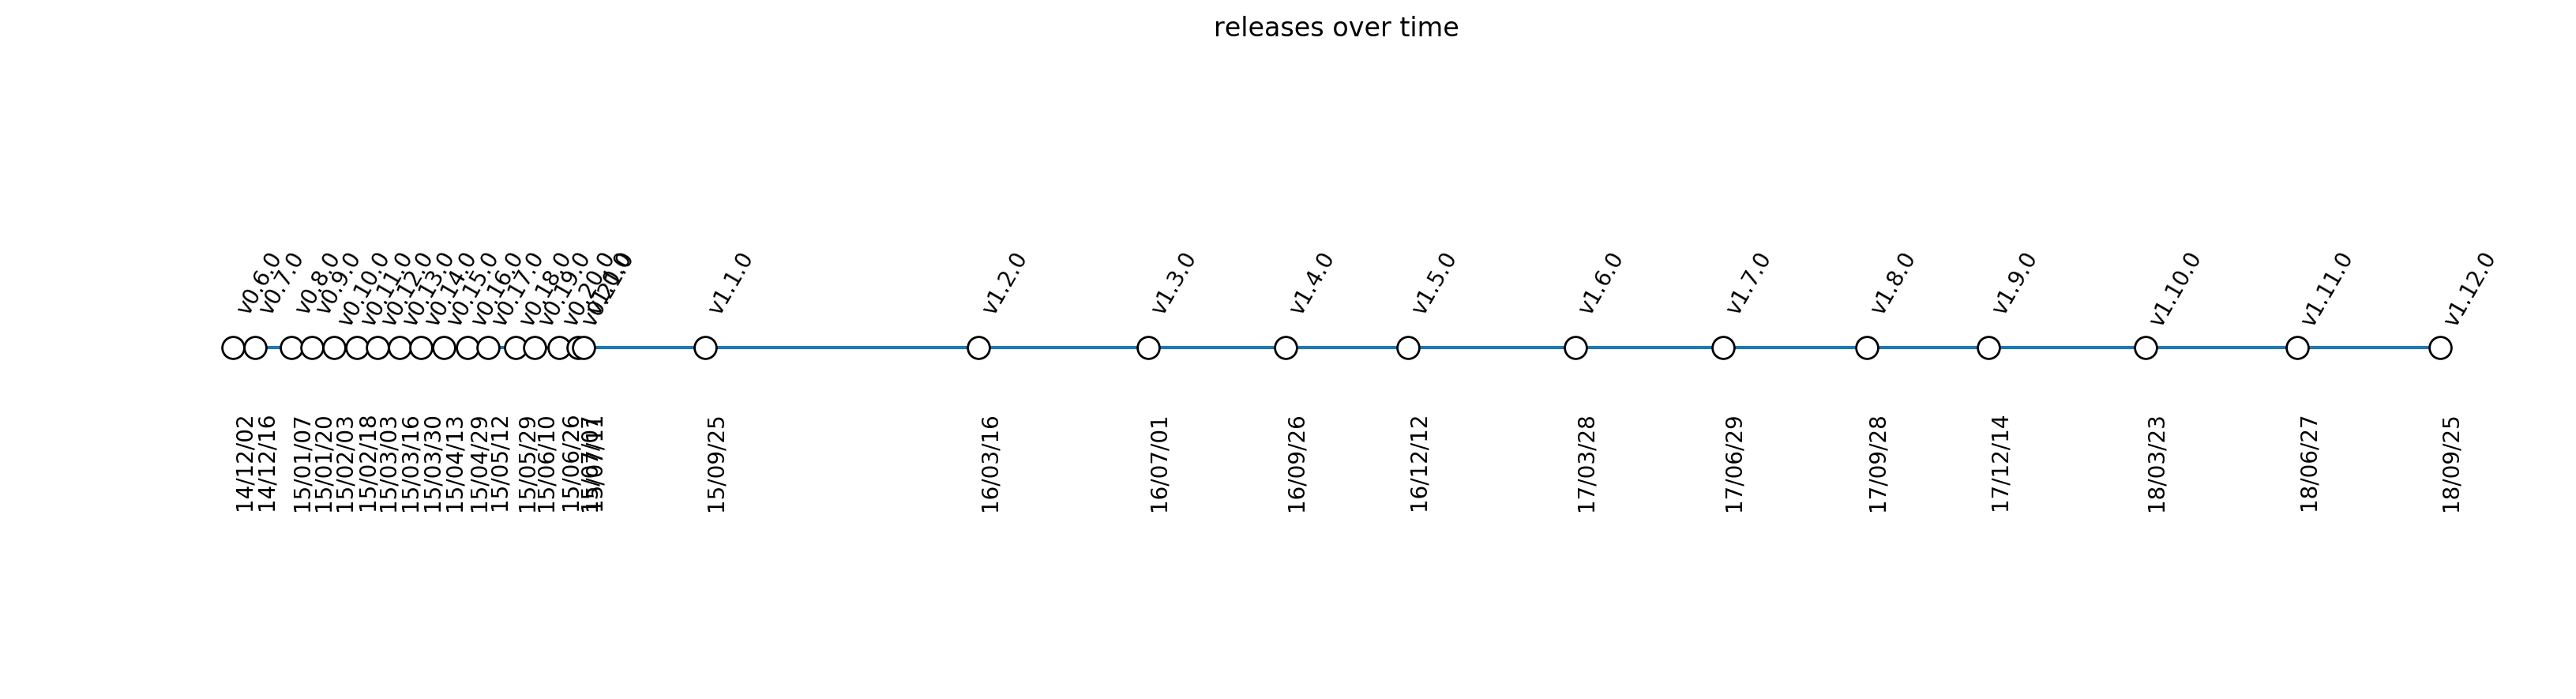

In [267]:
plt.figure(figsize=(20,5), dpi=200)

plt.title('releases over time')
zeros = [0]*len(release_timestamps)
plt.scatter(release_timestamps, zeros, s=100, facecolor='w', edgecolor='k', zorder=9999)
plt.plot(release_timestamps, zeros)

plt.axis('off')

for (i, ts) in enumerate(release_timestamps):
    plt.text(ts, 0.002, release_names[i], rotation=60)

for (i, ts) in enumerate(release_timestamps):
    plt.text(ts, -0.002, release_timestamps[i].strftime('%y/%m/%d'), rotation=90)

plt.show()

Next, it's time to count how many files we can reach from a given commit hash.

The important thing to see here is how we go from commit hash to tree hash thanks to the `commit_trees` table, to then obtain all of the `tree_entry_name`s corresponding to the the tree hashes using `tree_entries`.

In [46]:
# tree hashes for first commit ever

def count_files_in_commit(hash):
  (trees,) = zip(*run('''
    SELECT tree_hash
    FROM commit_trees
    WHERE commit_hash='%s'
  ''' % hash, log=False))

  (names,) = zip(*run('''
    SELECT file_path
    FROM files
    WHERE repository_id = 'kubernetes'
      AND tree_entry_mode != 40000
      AND file_path NOT LIKE 'vendor/%%'
      AND file_path NOT LIKE 'Godeps/%%'
      AND file_path NOT LIKE 'third_party/%%'
      AND file_path NOT LIKE '%%/internal/%%'
      AND tree_hash in (%s)
  ''' % ', '.join(['"%s"' % x for x in trees]), log=False))

  return len(names)

Ok, let's use that function we just created. But how much detail do we need? Here we're analyzing one every 1000 commits and it will take around 30 seconds to finish.

If you go down to every 100 commits expect to spend a couple of minutes waiting.

In [47]:
from joblib import Parallel, delayed
import multiprocessing

indexes = range(0, len(commits), 1000)

In [48]:
file_counts = Parallel(n_jobs=-1, verbose=10)(
    delayed(count_files_in_commit)(commits[i]) for i in indexes)
file_counts = {indexes[i]: n for (i, n) in enumerate(file_counts)}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  73 | elapsed:  2.6min remaining: 93.9min
[Parallel(n_jobs=-1)]: Done  10 out of  73 | elapsed:  2.7min remaining: 16.8min
[Parallel(n_jobs=-1)]: Done  18 out of  73 | elapsed:  2.7min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done  26 out of  73 | elapsed:  2.7min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  34 out of  73 | elapsed:  2.7min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  42 out of  73 | elapsed:  2.7min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:  2.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:  2.7min remaining:   42.2s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:  2.7min remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:  2.7min finished


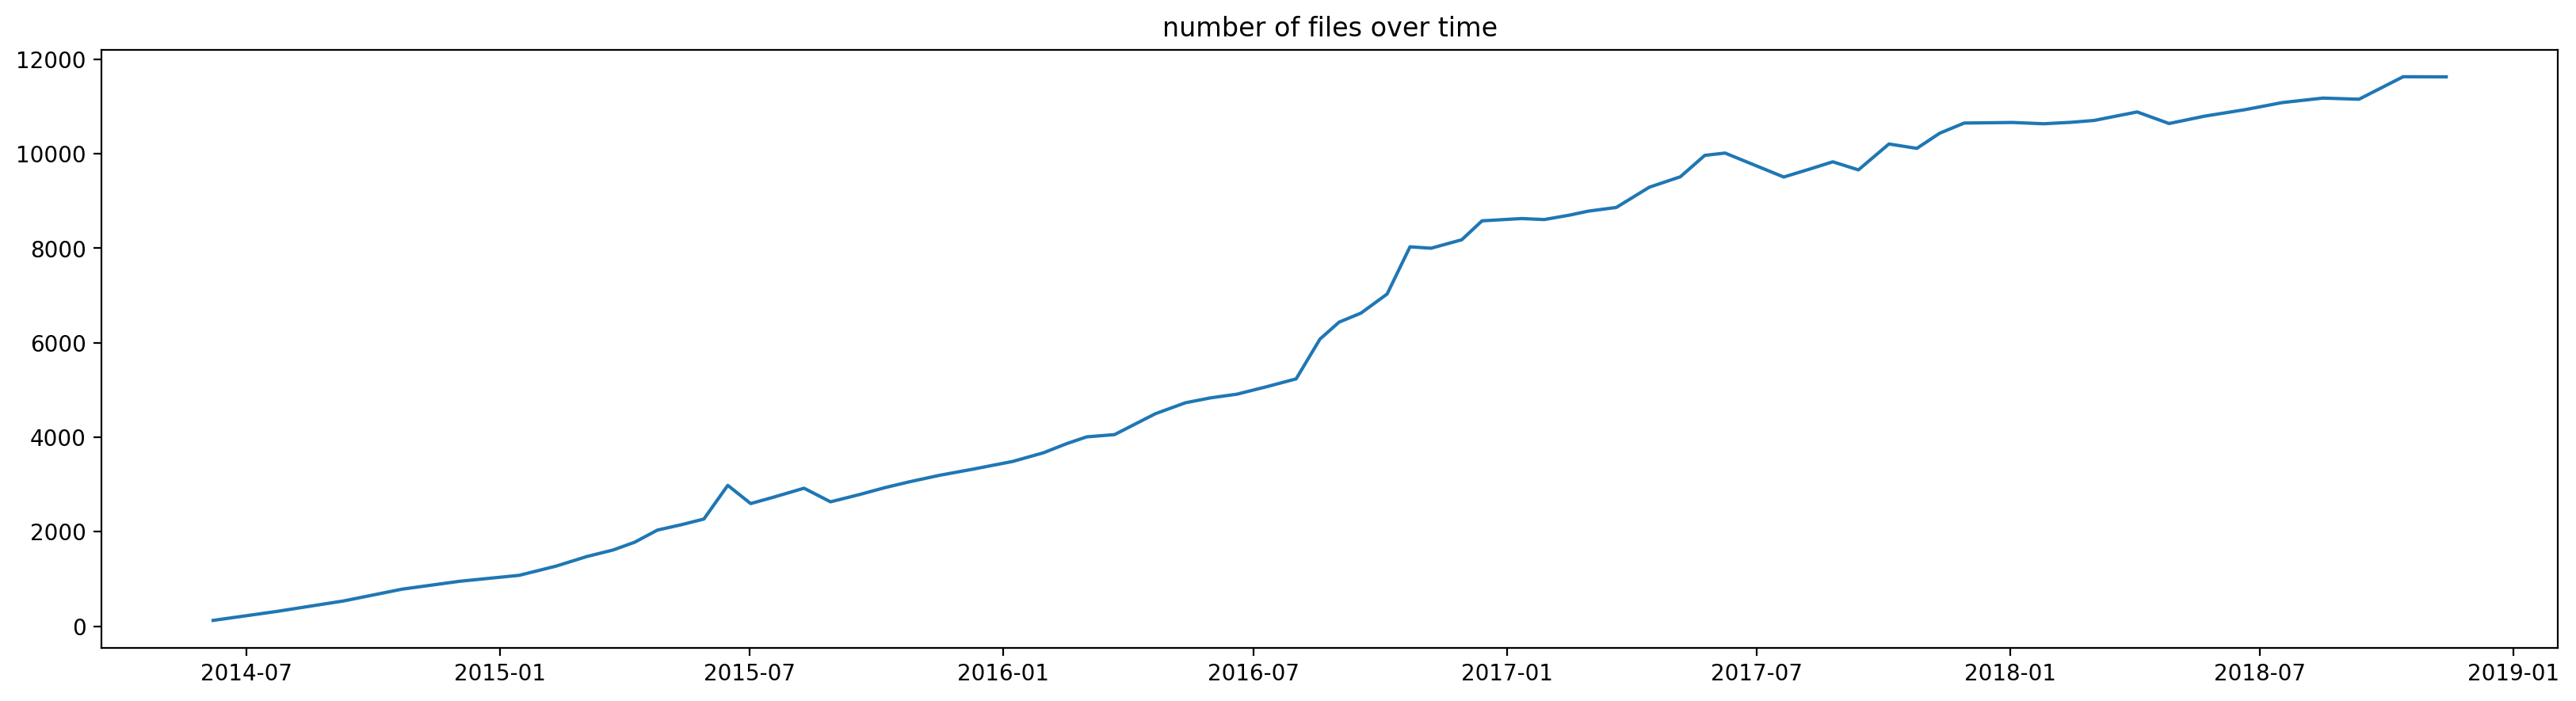

In [50]:
(ts, fs) = zip(*[(timestamps[i], file_counts[i]) for i in indexes])
plt.figure(figsize=(20,5), dpi=200)
plt.title('number of files over time')
plt.plot(ts, fs)
plt.show()

In [51]:
def count_lines_in_commit(commit):
    (trees,) = zip(*run('''
    SELECT tree_hash
    FROM commit_trees
    WHERE commit_hash='%s'
    ''' % commit, log=False))

    (names, hashes,) = zip(*run('''
    SELECT file_path, blob_hash
    FROM files
    WHERE repository_id = 'kubernetes'
      AND tree_entry_mode != 40000
      AND file_path NOT LIKE 'vendor/%%'
      AND file_path NOT LIKE 'Godeps/%%'
      AND file_path NOT LIKE 'third_party/%%'
      AND file_path NOT LIKE '%%/internal/%%'
      AND tree_hash in (%s)
    ''' % ', '.join(['"%s"' % x for x in trees]), log=False))

    (lines,) = run_one('''
    SELECT SUM(ARRAY_LENGTH(SPLIT(blob_content, '\n'))-1)
    FROM blobs
    WHERE repository_id = 'kubernetes'
      AND blob_hash IN (%s)
    ''' % ', '.join(['"%s"' % x for x in hashes]), log=False)

    return int(lines)

In [52]:
line_counts = Parallel(n_jobs=-1, verbose=10)(
    delayed(count_lines_in_commit)(commits[i]) for i in indexes)
line_counts = {indexes[i]: n for (i, n) in enumerate(line_counts)}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  73 | elapsed:  2.9min remaining: 102.1min
[Parallel(n_jobs=-1)]: Done  10 out of  73 | elapsed:  3.0min remaining: 19.1min
[Parallel(n_jobs=-1)]: Done  18 out of  73 | elapsed:  3.2min remaining:  9.8min
[Parallel(n_jobs=-1)]: Done  26 out of  73 | elapsed:  3.3min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  34 out of  73 | elapsed:  3.5min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  42 out of  73 | elapsed:  3.6min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:  3.8min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:  3.8min remaining:   59.5s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:  3.8min remaining:   24.5s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:  3.9min finished


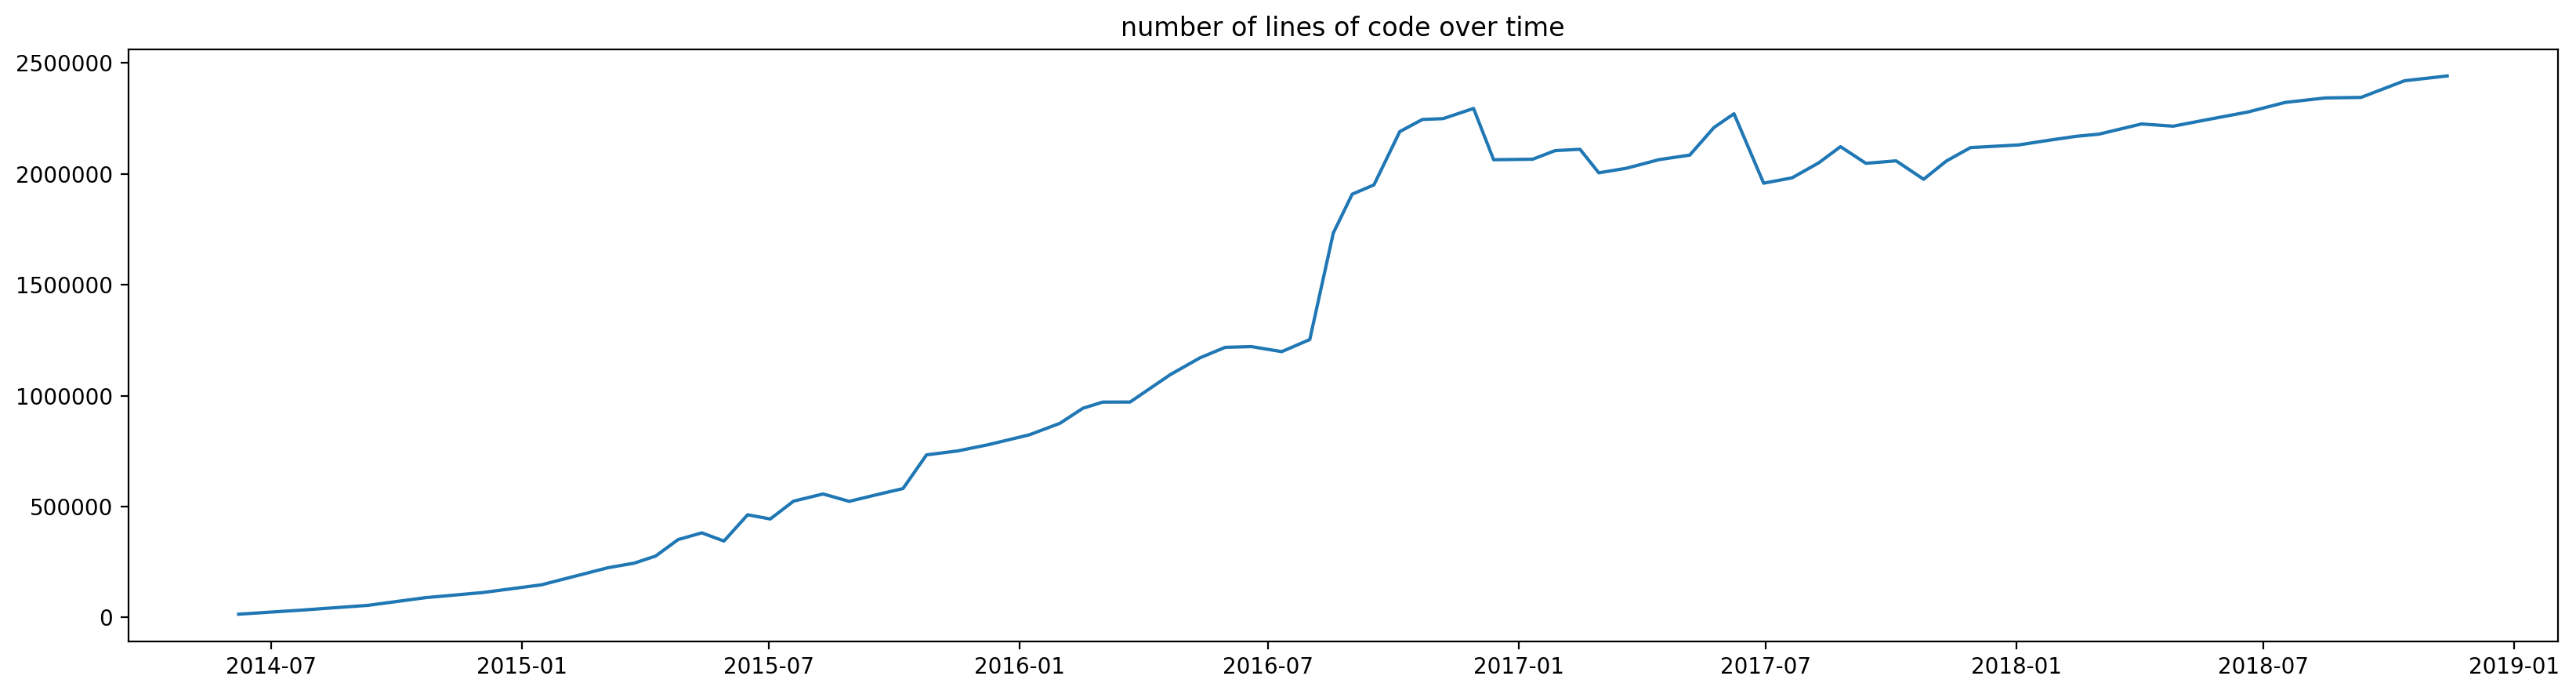

In [55]:
(ts, ls) = zip(*[(timestamps[i], line_counts[i]) for i in indexes])
plt.figure(figsize=(20,5), dpi=200)
plt.title('number of lines of code over time')
plt.plot(ts, ls)
plt.show()

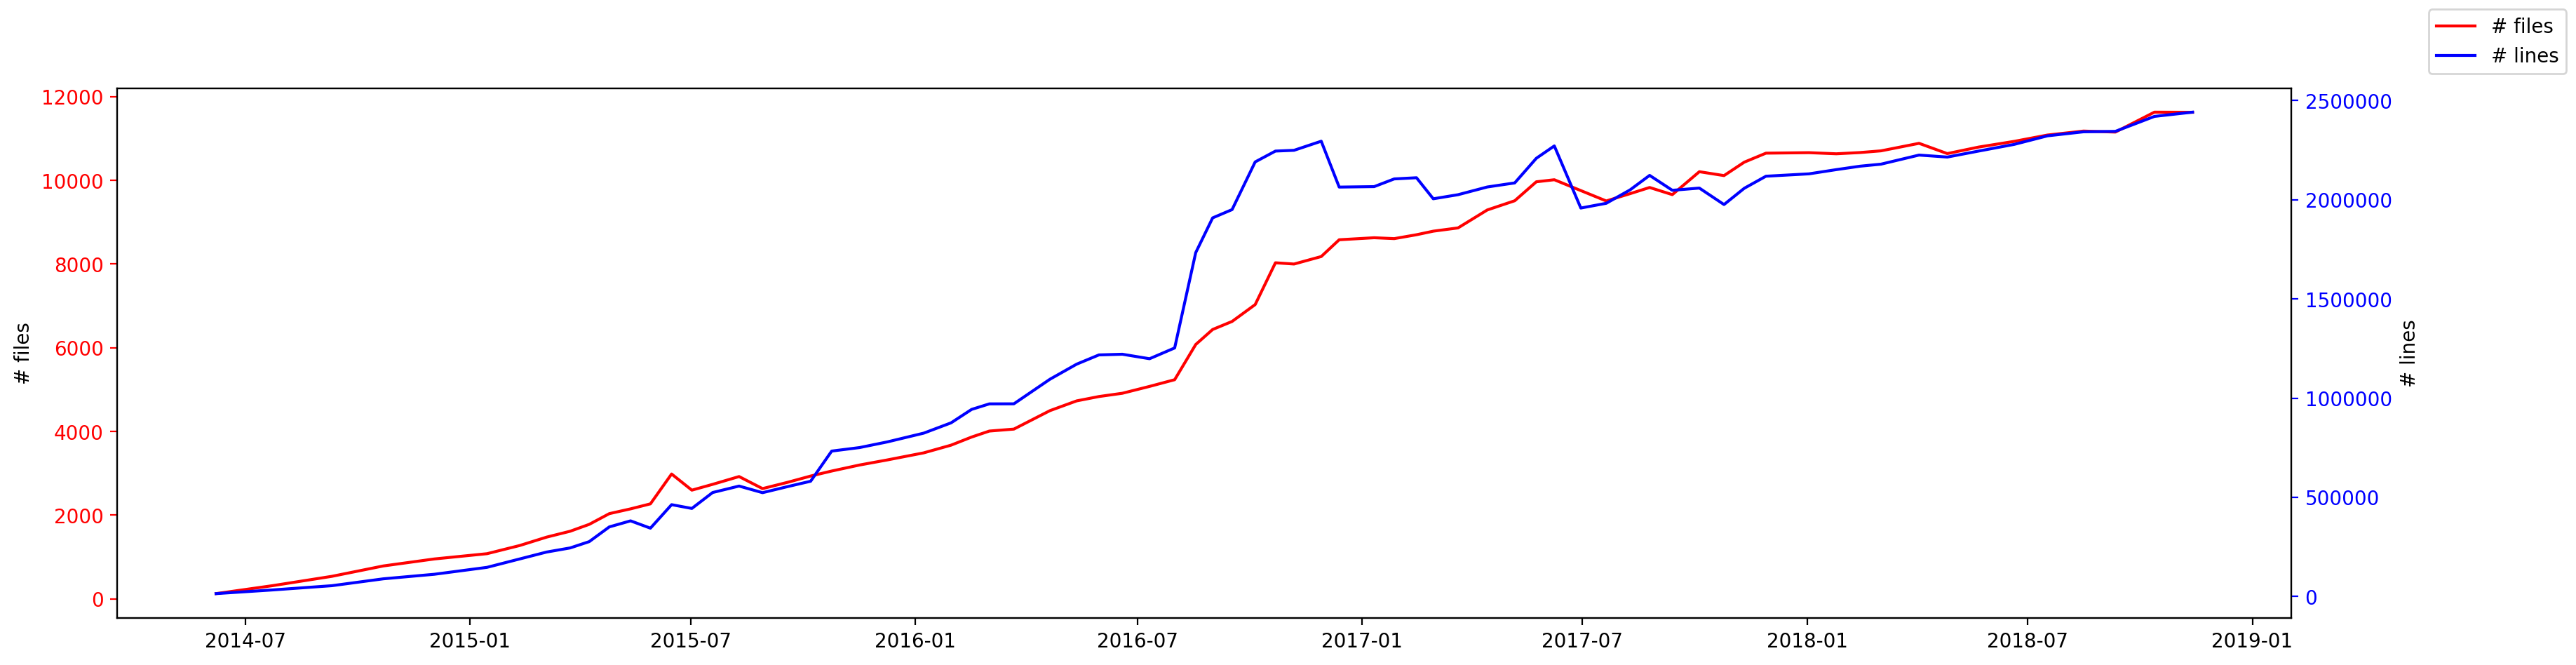

In [54]:
fig, ax1 = plt.subplots(figsize=(20,5), dpi=200)

ratio = np.mean(ls)/np.mean(fs)
ax1.plot(ts, fs, 'r-')
ax1.set_ylabel('# files')
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(ts, ls, 'b-')
ax2.set_ylabel('# lines')
ax2.tick_params('y', colors='b')

fig.legend(['# files', '# lines'])

plt.show()


### Understanding commit velocity

Imagine you need to answer the following question: are we committing more often than a year ago? What about the growth rate of that number of commits?

Well, let's simply count the number of commits per year/month and plot it.

In [56]:
(years, months, days, count) = zip(*run('''
  SELECT YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         DAY(commit_author_when) as day,
         COUNT(*) as n
  FROM commits
  GROUP BY year, month, day
  ORDER BY year, month, day
'''))

2018-12-05 23:26:19 instance-4 root[5533] INFO done in 15.36 seconds


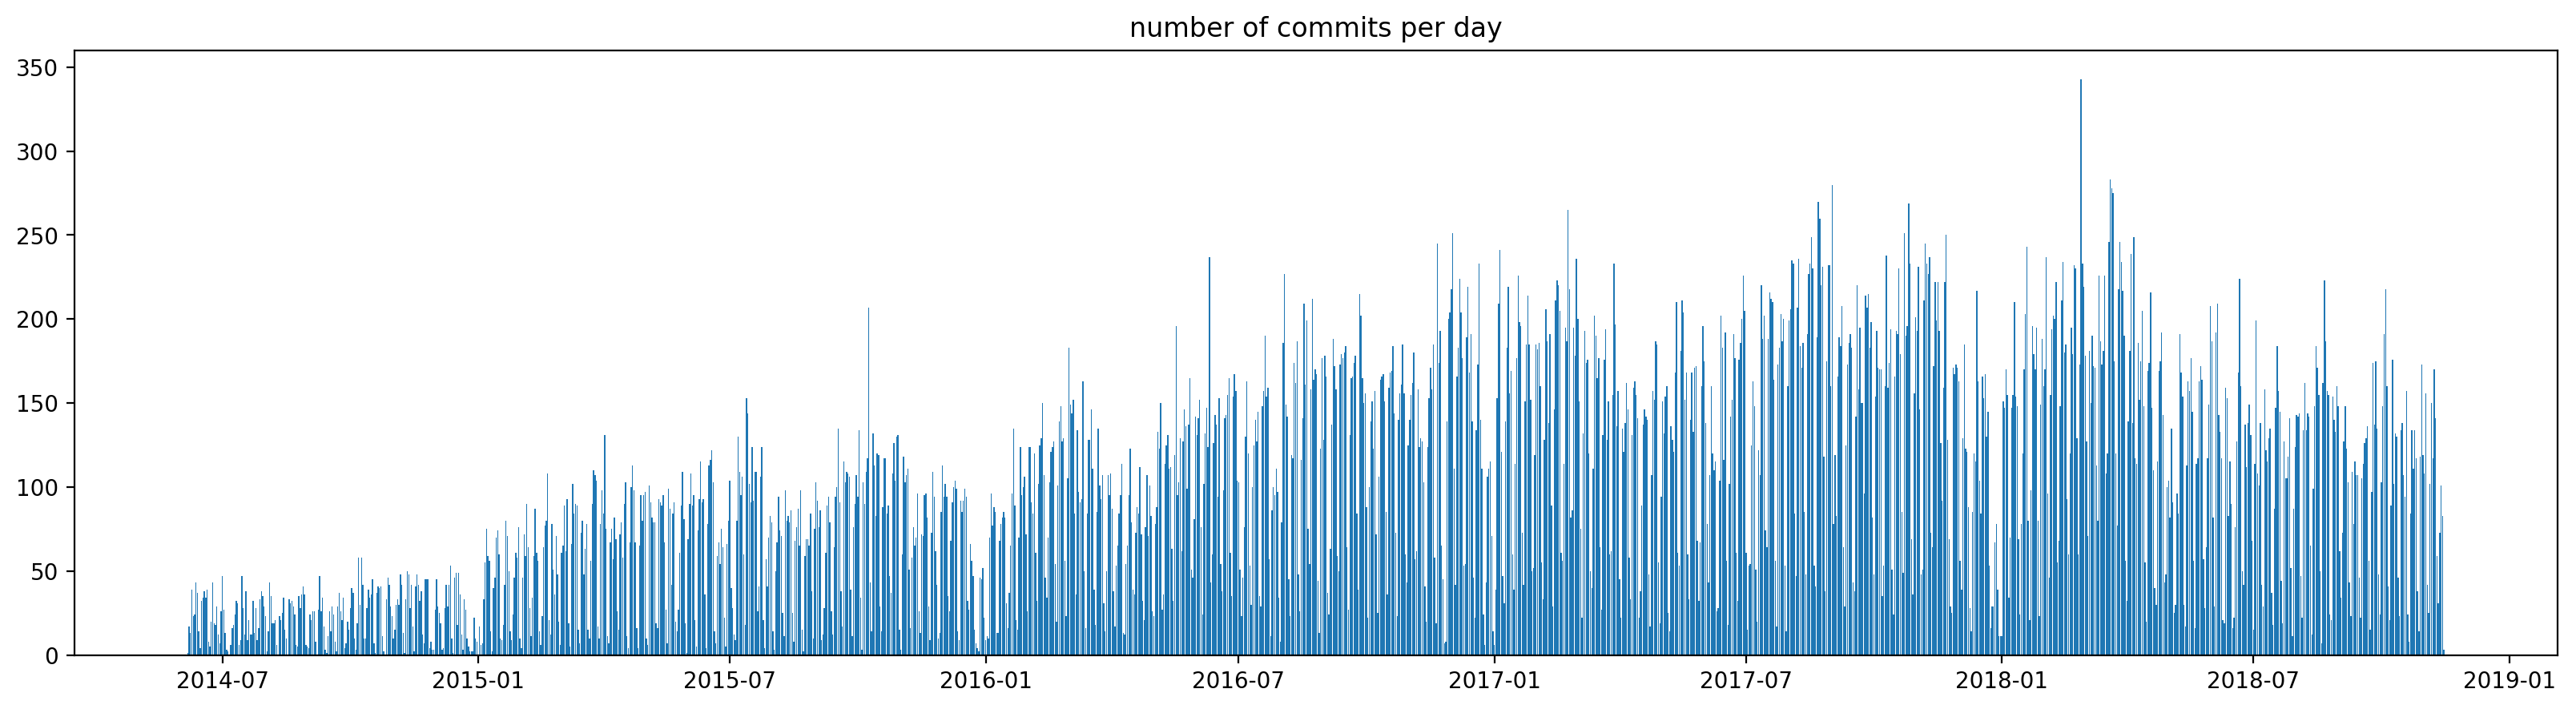

In [57]:
from datetime import datetime

dates = [datetime(year, month, day) for (year, month, day) in zip(years, months, days)]
plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits per day')
plt.bar(dates, count)
plt.show()

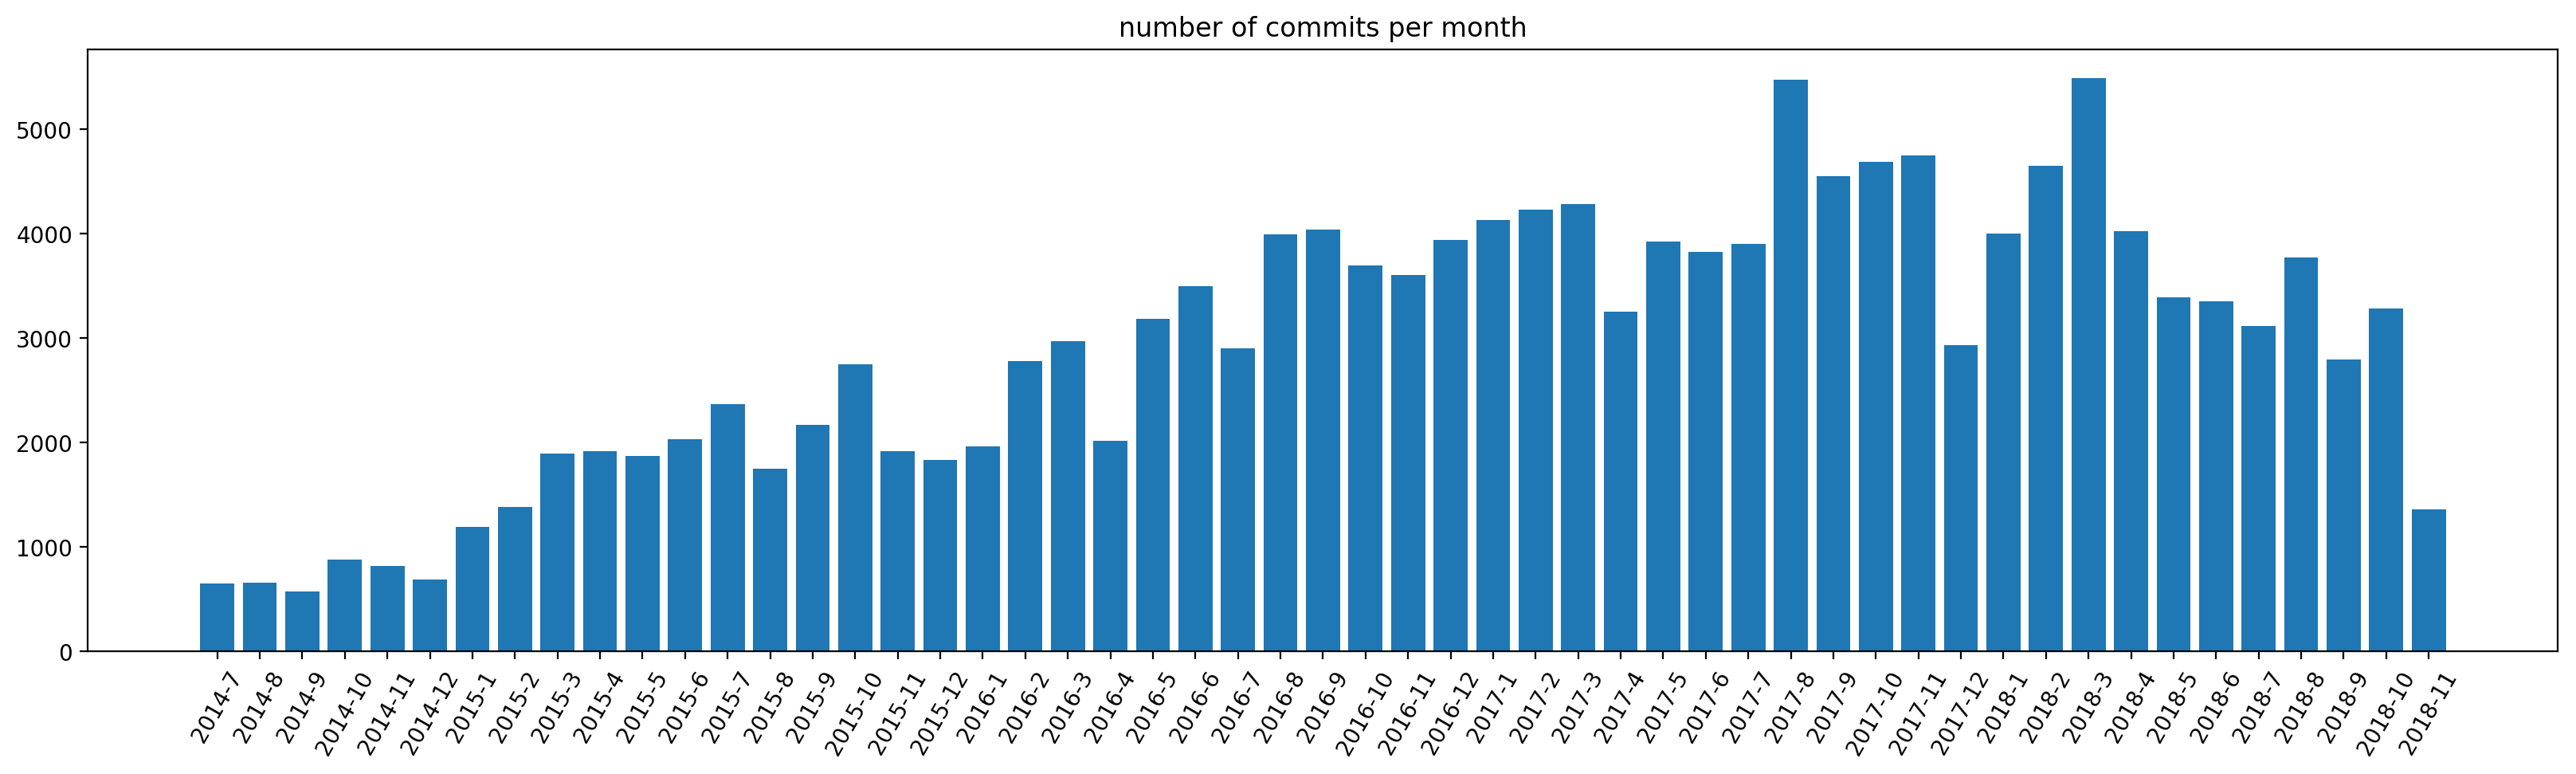

In [58]:
month_counts = {}
for year, month, day, c in zip(years, months, days, count):
    month_counts[(year, month)] = month_counts.get((year, month), 0) + c

month_dates = []
d = min(month_counts)
while d < max(month_counts):
    month = d[1] + 1 if d[1] < 12 else 1
    year = d[0] + (1 if month == 1 else 0)
    d = (year, month)
    month_dates.append(d)

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits per month')
plt.bar(['%d-%d'%d for d in month_dates], [month_counts[d] for d in month_dates])
plt.xticks(rotation=60)
plt.show()

Great, so this allows us to see how the number of commits evolved over time. But what if we want to separate by repositories?

It shouldn't be hard, with the power of SQL!

In [112]:
(repos, years, months, counts) = zip(*run('''
  SELECT repository_id as repo,
         YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         COUNT(*) as n
  FROM commits
  GROUP BY repo, year, month
  ORDER BY repo, year, month
'''))

2018-12-05 23:56:14 instance-4 root[5533] INFO done in 34.94 seconds


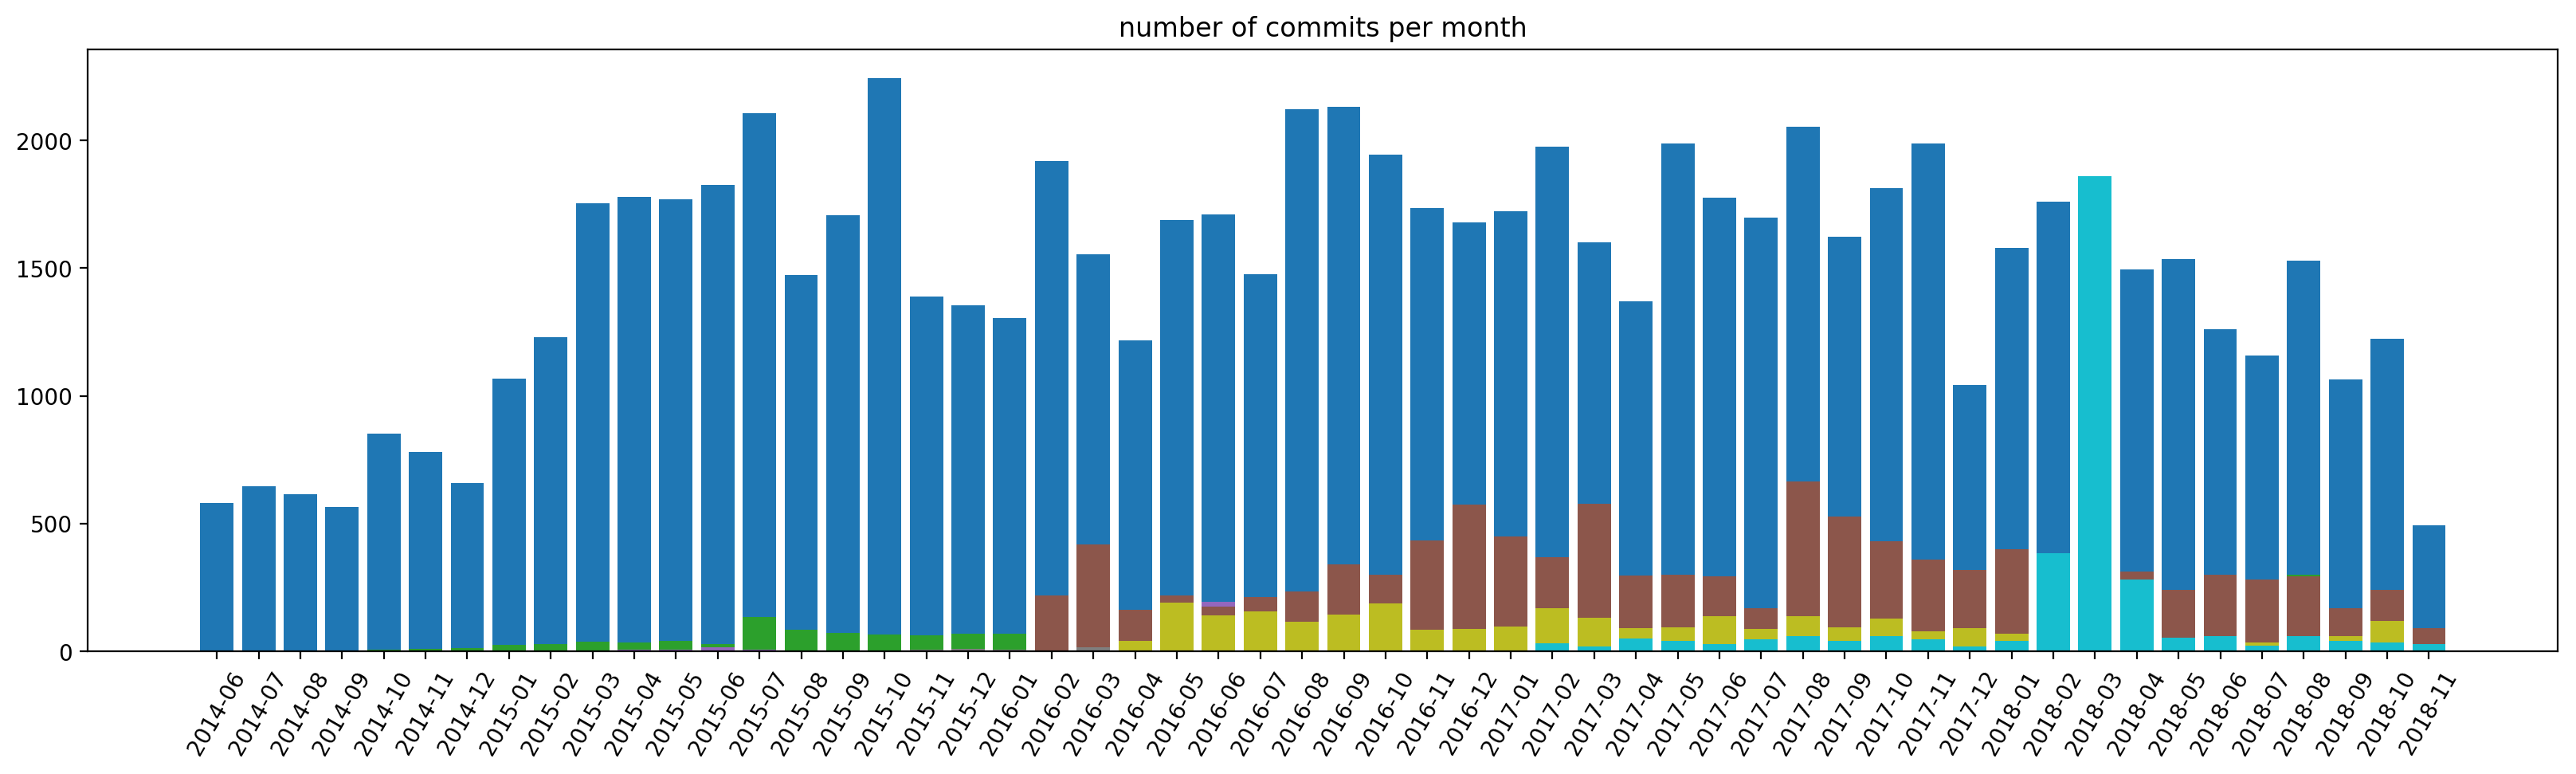

In [154]:
values = {repo: {} for repo in repos}
for repo, year, month, count in zip(repos, years, months, counts):
    values[repo][datetime(year, month, 1)] = values[repo].get(datetime(year, month, 1), 0) + count

dates = [datetime(year, month, 1) for (year, month) in zip(years, months)]
min_date = min(dates)
max_date = max(dates)

dates = []
d = min_date
while d <= max_date:
    dates.append(d)
    month = d.month + 1 if d.month < 12 else 1
    year = d.year + (1 if month == 1 else 0)
    d = datetime(year, month, 1)

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits per month')
for value in values.values():
    plt.bar([d.strftime('%Y-%m') for d in dates], [value.get(d, 0) for d in dates])

plt.xticks(rotation=60)
plt.show()

In [197]:
(repos, years, counts) = zip(*run('''
  SELECT repository_id as repo,
         YEAR(commit_author_when) as year,
         COUNT(*) as n
  FROM commits
  GROUP BY repo, year
  ORDER BY repo, year
'''))

2018-12-06 00:46:01 instance-4 root[5533] INFO done in 15.22 seconds


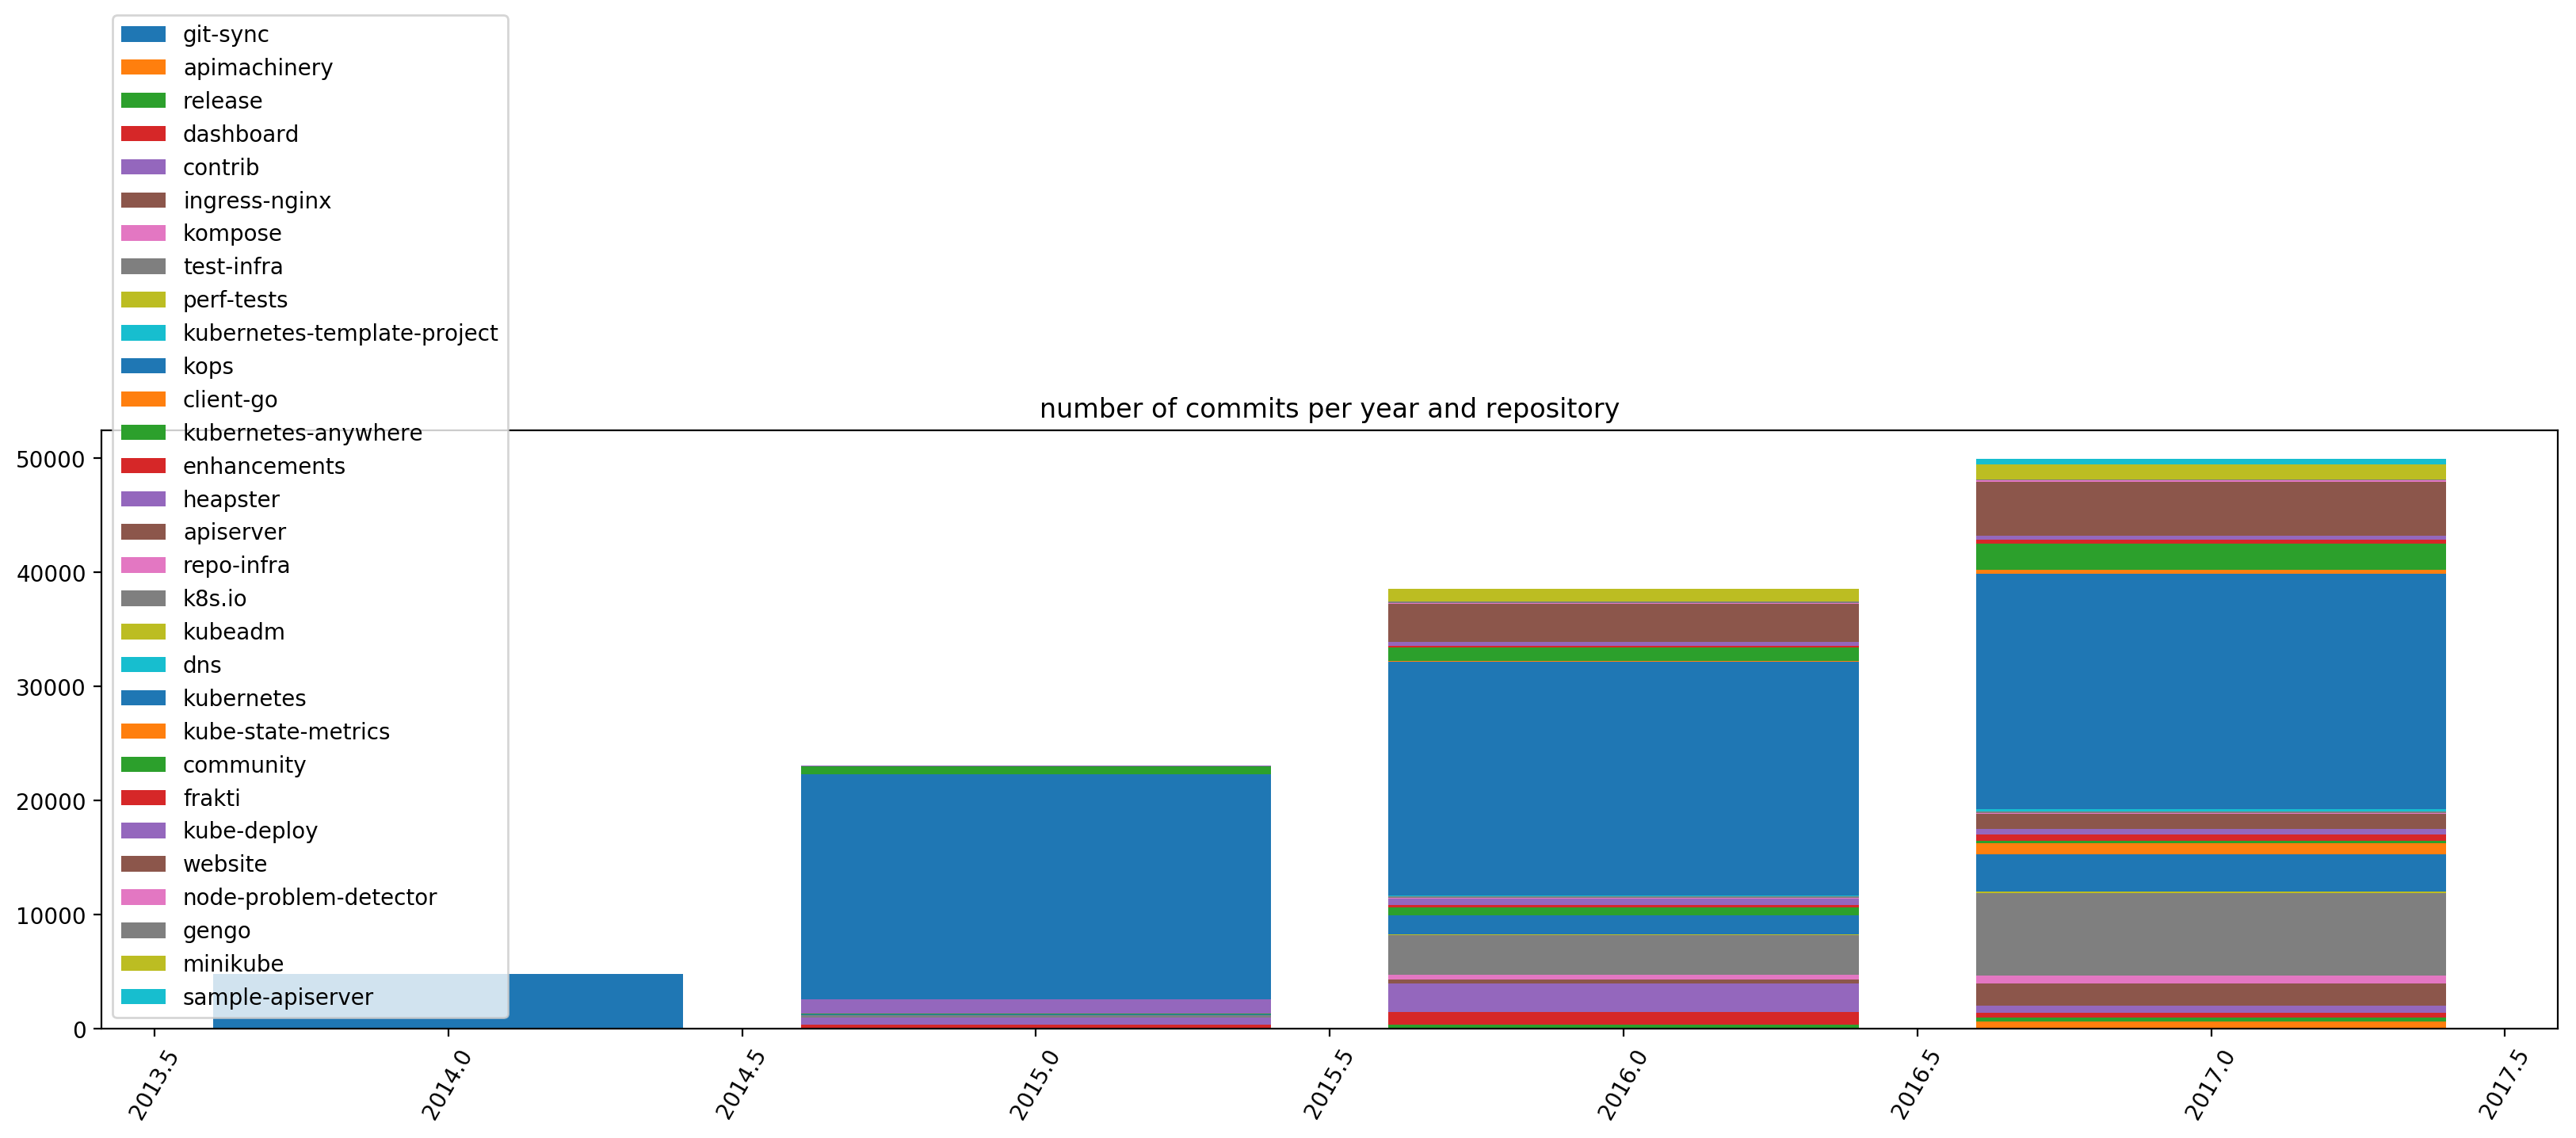

In [198]:
values = {repo: {} for repo in repos}
for repo, year, count in zip(repos, years, counts):
    values[repo][year] = values.get(year, 0) + count

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits per year and repository')

years = list(range(min(years), max(years)))
bottom = np.zeros(len(years))
for repo in values:
    vals = [values[repo].get(year, 0) for year in years]
    plt.bar(years, vals, bottom=bottom)
    bottom += vals

plt.legend(values.keys())
plt.xticks(rotation=60)
plt.show()

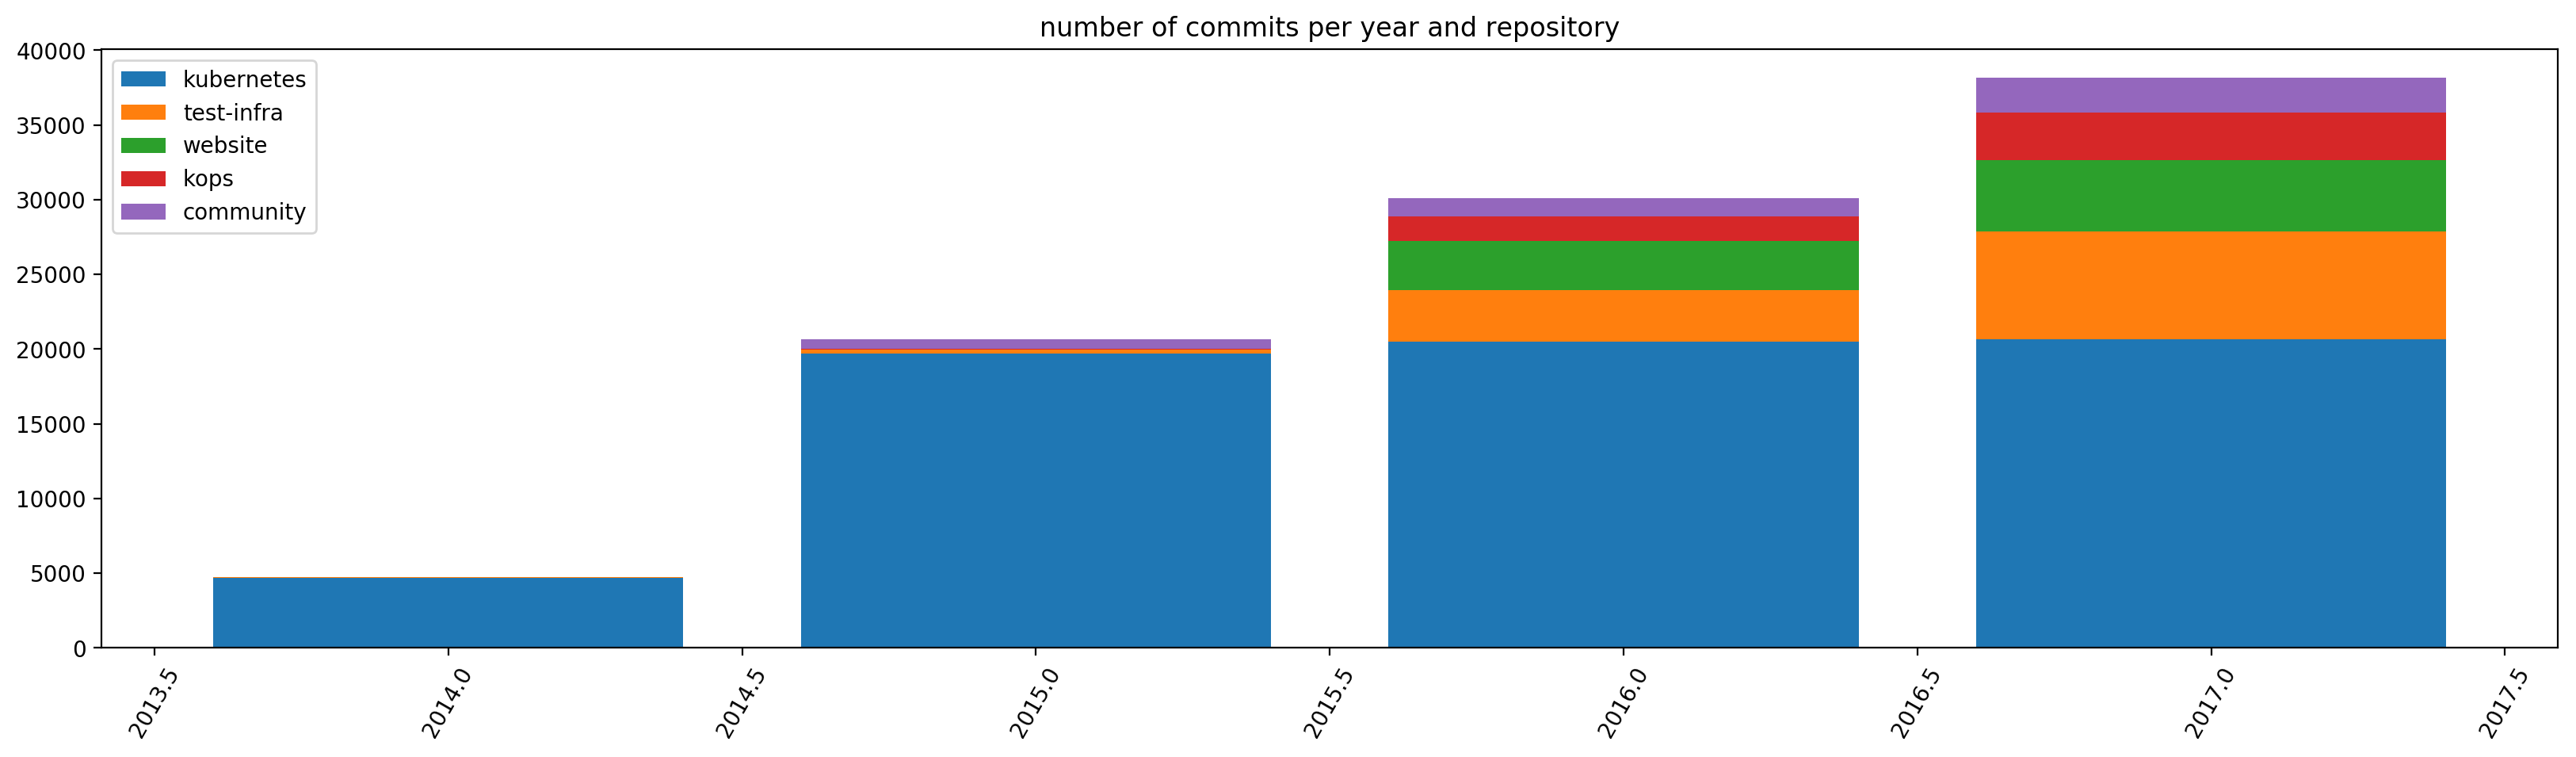

In [203]:
totals = [(repo, sum(values[repo].values())) for repo in values]
large_repos = [v[0] for v in sorted(totals, key=lambda x: -x[1])[:5]]

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits per year and repository')

bottom = np.zeros(len(years))
for repo in large_repos:
    vals = [values[repo].get(year, 0) for year in years]
    plt.bar(years, vals, bottom=bottom)
    bottom += vals

plt.legend(large_repos)
plt.xticks(rotation=60)
plt.show()

This graph is a little bit too noisy. Let's limit the graph to only the projects in the top 10 number of commits.

### Analyzing contributor behavior

One of the pieces of information we can extract from a git repository is the identity of the contributor for each commit. Let's use that to try to track who's there. Let's start counting the number of contributors per repository!

In [ ]:
# difference between commit author and committer:
# https://stackoverflow.com/questions/6755824/what-is-the-difference-between-author-and-committer-in-git

rows = run("""
SELECT repository_id, SUM(commit_count) as commit_count, COUNT(*) as contributor_count
FROM (
  SELECT repository_id, commit_author_email, COUNT(*) as commit_count
  FROM commits
  GROUP BY repository_id, commit_author_email
) as t
GROUP BY repository_id;
""")


repos, commits, contributors = zip(*rows)

fig, s = plt.subplots(figsize=(20,10))
s.scatter(contributors, commits)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('#contributors'); plt.ylabel('#commits')
for i, repo in enumerate(repos):
    s.annotate(repo, (contributors[i], commits[i]))
plt.show()

This query allowed us to see that there's a clear (and expected) correlation between the number of contributors and number of contributions although some repositories have more productive contributors than others, for instance `ggrc-core` and `skia-buildbot` seem to have a really large number of contributions/contributor, while `go-github` seems to have more "one-off" contributions.

In [ ]:
import operator

l = list(zip(repos, commits, contributors, np.array(commits)/np.array(contributors)))
l.sort(key=operator.itemgetter(3))

headers = '%30s % 10s % 10s %10s'  % ('repository', 'commits', 'contribs', 'ratio')
headers = '\n' + headers + '\n' + '-' * len(headers)
template = '%30s % 10d % 10d % 10.2f'

print('repos with most productive contributors:')
print(headers)
for r in l[:5]:
  print(template % r)

print('\nrepos with least productive contributors:')
print(headers)
for r in l[-5:]:
  print(template % r)


Tunrns out both `go-github` has only around 3.5 contributions per contributor, which points in the direction of a repository where many people contribute once and go away.

On the other hand, `wuffs` and `puffs` have only three contributors that are incredibly prolific!

In [ ]:
(repos, commits, contributors, ratios) = zip(*l)
fig, s = plt.subplots(figsize=(20,30))
x = np.arange(len(l))
plt.barh(x, ratios)
plt.xscale('log')
plt.yticks(x, repos)

for (i, repo) in enumerate(repos):
    s.text(ratios[i], i-0.25, '%d/%d' % (commits[i], contributors[i]), color='blue')

plt.show()

Great, this allows us to easily identify which repositories have the most engaged contributors. But how many of those contributors contribute to more than one of these projects? Let's see that now!

In [ ]:
emails, repos, commits = zip(*run("""
  SELECT commit_author_email, COUNT(*) as repos_count, SUM(commit_count) as commit_count
  FROM (
    SELECT repository_id, commit_author_email, COUNT(*) as commit_count
    FROM commits
    GROUP BY repository_id, commit_author_email
  ) as t
  GROUP BY commit_author_email;
"""))

In [ ]:
buckets = np.arange(np.min(repos), np.max(repos)+1)
data = [[c for (i, c) in enumerate(commits) if repos[i] == bucket] for bucket in buckets]
fig, s = plt.subplots(figsize=(20,5))
s.scatter(repos, commits, marker='.')
s.boxplot(data, boxprops=dict(color='k'))
plt.yscale('log')
plt.xlabel('#repos')
plt.ylabel('#commits')
plt.show()

It is clear that there's a correlation: contributors that contribute more tend to contribute to a larger number of repositories.

But it's important to point out that many contributors that participate in a single repository might still be incredibly prolific as the many ouliers on the first column show.



### Detecting languages

Once we have all the files in a repository we can easily find the corresponding blob and classify the language it was written in by using the `LANGUAGE` custom function.

`LANGUAGE` receives two parameters: the file path and its content.

In [316]:
langs, counts = zip(*run("""
SELECT lang, COUNT(*) as n
FROM (
    SELECT LANGUAGE(cf.file_path, f.blob_content) as lang
    FROM   files AS f
           NATURAL JOIN commit_files cf
           NATURAL JOIN refs
    WHERE  ref_name = 'HEAD'
           AND repository_id = 'kubernetes'
           AND file_path NOT LIKE 'vendor/%%'
           AND file_path NOT LIKE 'Godeps/%%'
           AND file_path NOT LIKE 'third_party/%%'
           AND file_path NOT LIKE '%%/internal/%%'           
) AS t
WHERE lang is not null
GROUP BY lang
ORDER BY 2 DESC
"""))

2018-12-06 02:11:25 instance-4 root[5533] INFO done in 2.23 seconds


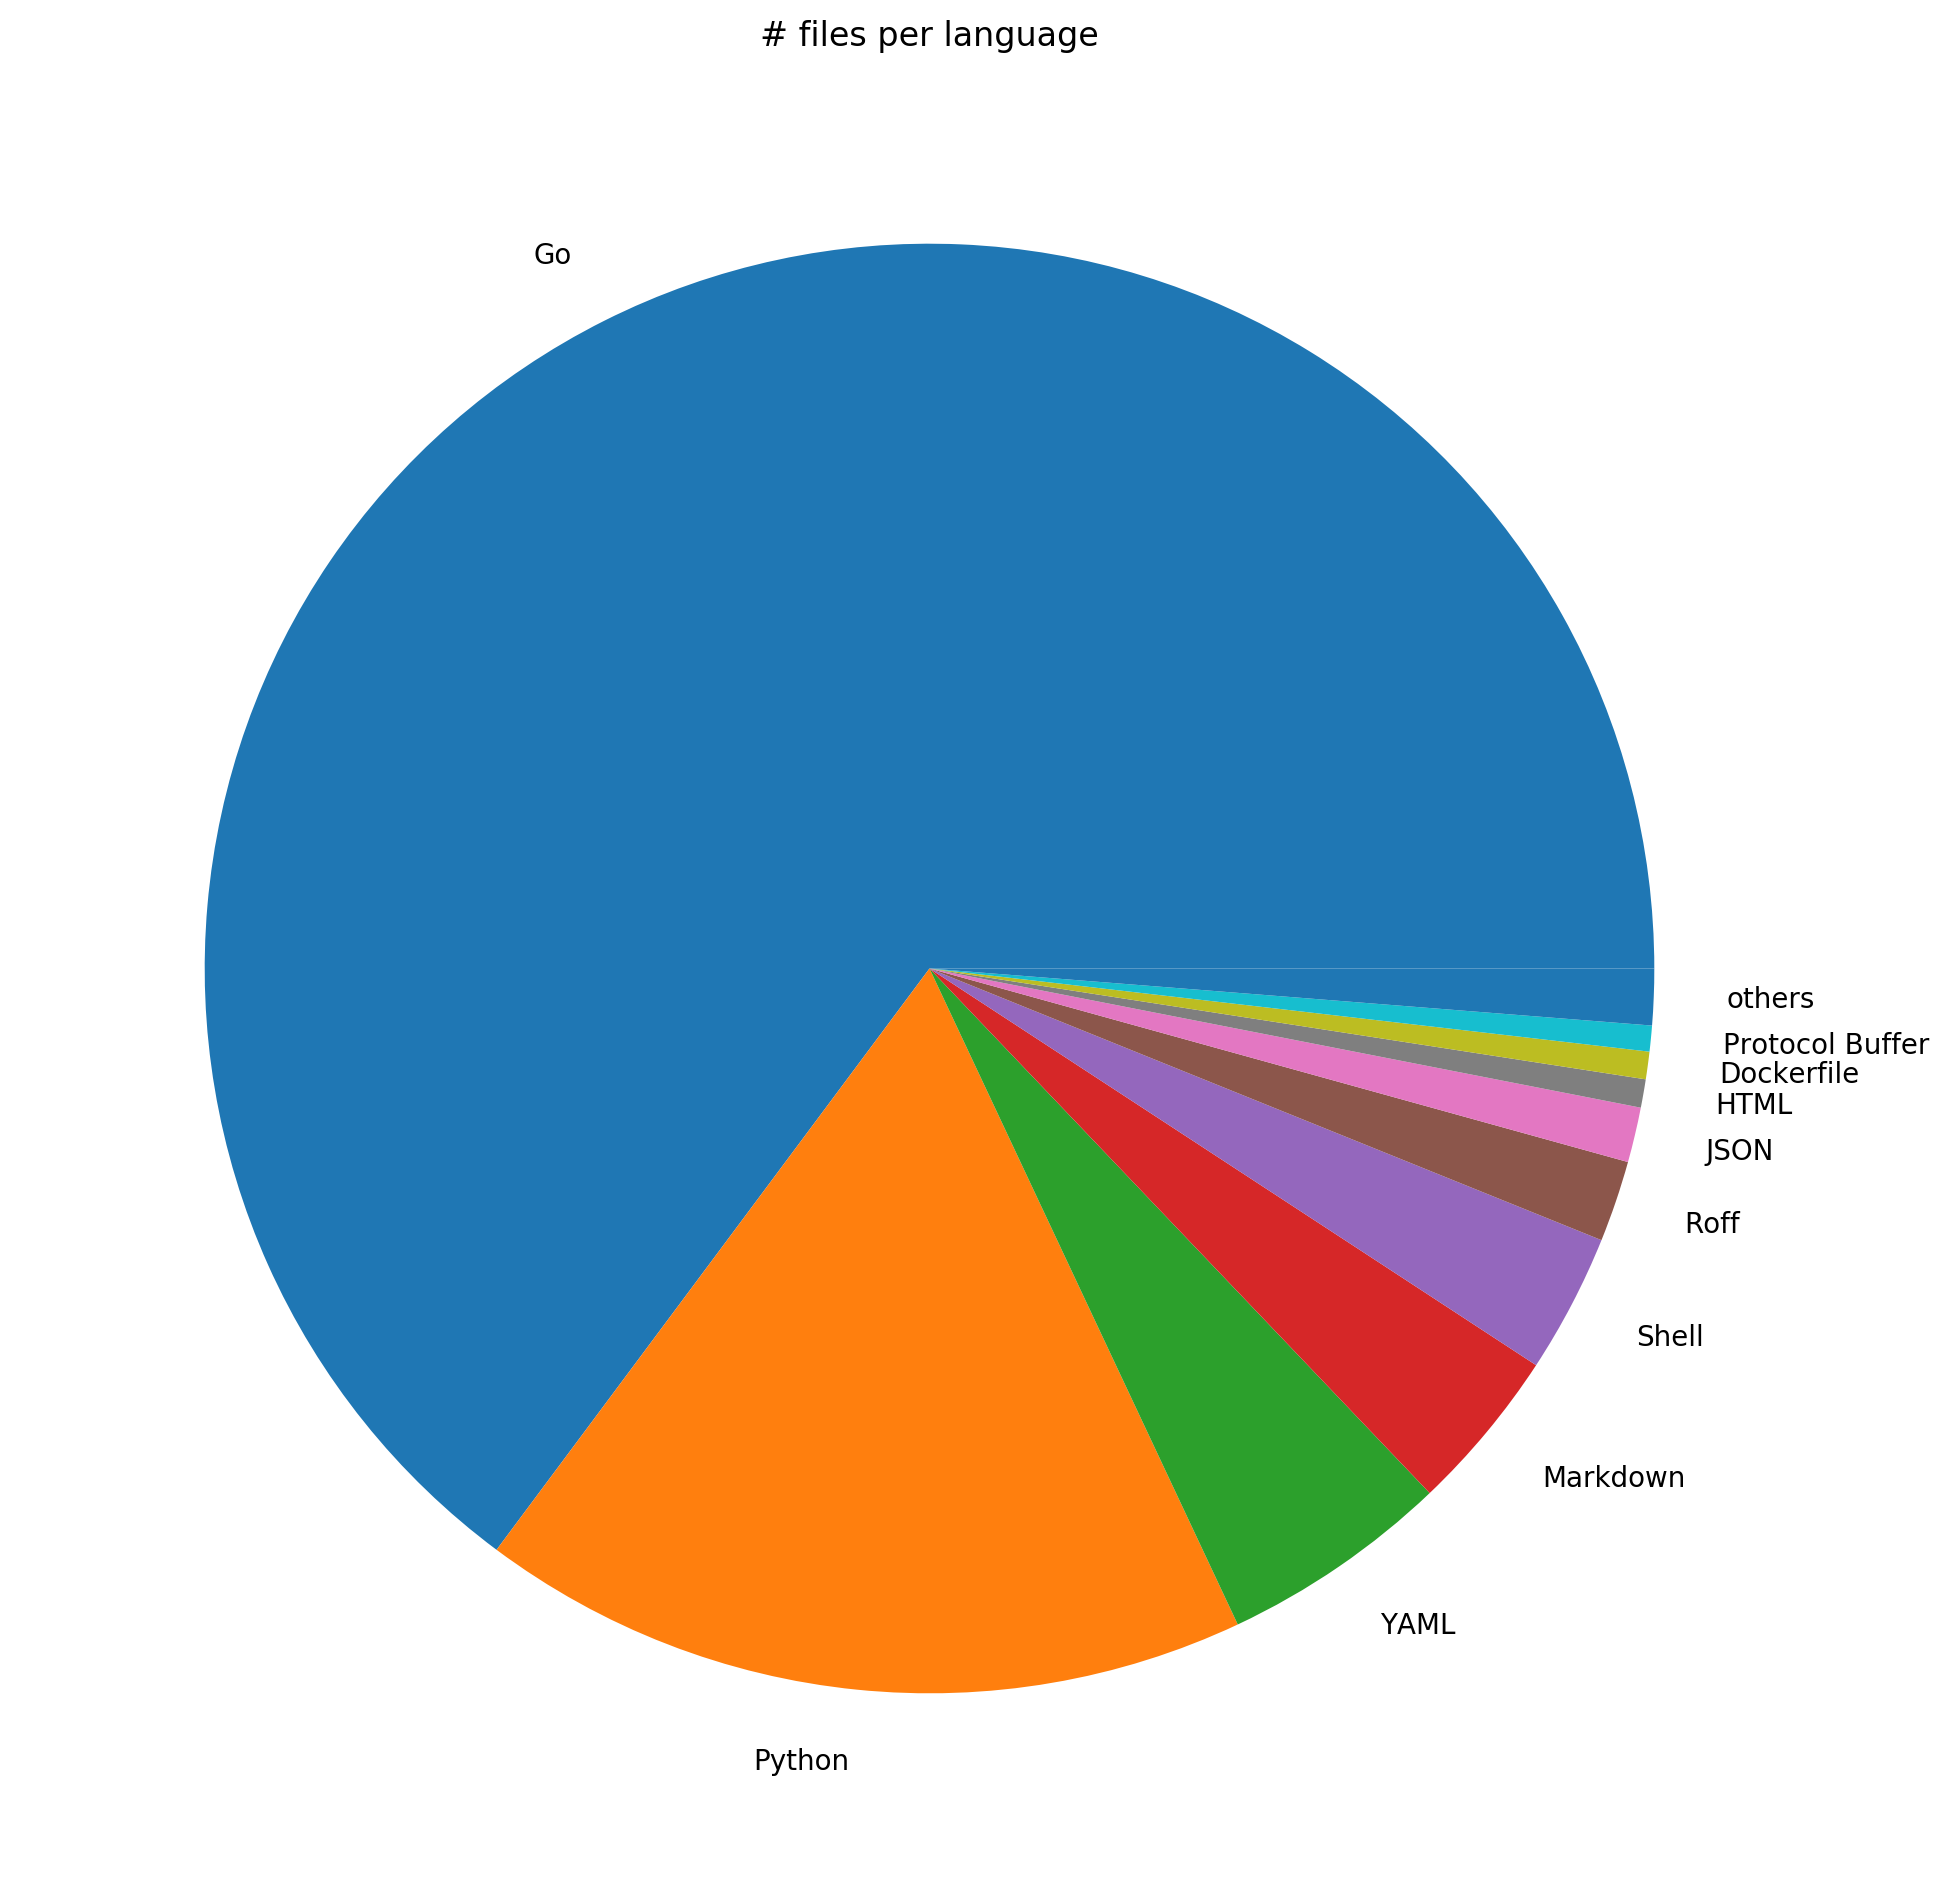

In [317]:
percents = [(100*c)/sum(counts) for c in counts if c/sum(counts) > 0.005]
if len(percents) < len(langs):
    percents.append(100 - sum(percents))
    labels = langs[:len(percents)-1] + ('others',)
else:
    labels = langs

plt.figure(figsize=(12,12), dpi=200)
plt.title('# files per language')
plt.pie(percents, labels=labels)
plt.show()

What about the number of lines of code?

In [308]:
langs, counts = zip(*run("""
SELECT lang, SUM(n)
FROM (
    SELECT lang, SUM(lines) as n
    FROM (
        SELECT f.repository_id, LANGUAGE(cf.file_path, f.blob_content) as lang,
               ARRAY_LENGTH(SPLIT(f.blob_content, '\n')) as lines
        FROM   files AS f
               NATURAL JOIN commit_files cf
               NATURAL JOIN refs
        WHERE  ref_name = 'HEAD'
           AND file_path NOT LIKE 'vendor/%%'
           AND file_path NOT LIKE 'Godeps/%%'
           AND file_path NOT LIKE 'third_party/%%'
           AND file_path NOT LIKE '%%/internal/%%'           
    ) AS t
    WHERE lang IS NOT NULL
    GROUP BY repository_id, lang
) AS t
GROUP by lang
ORDER BY n DESC
"""))

2018-12-06 02:09:46 instance-4 root[5533] INFO loading data, will take a couple of seconds
2018-12-06 02:10:10 instance-4 root[5533] INFO done in 23.61 seconds


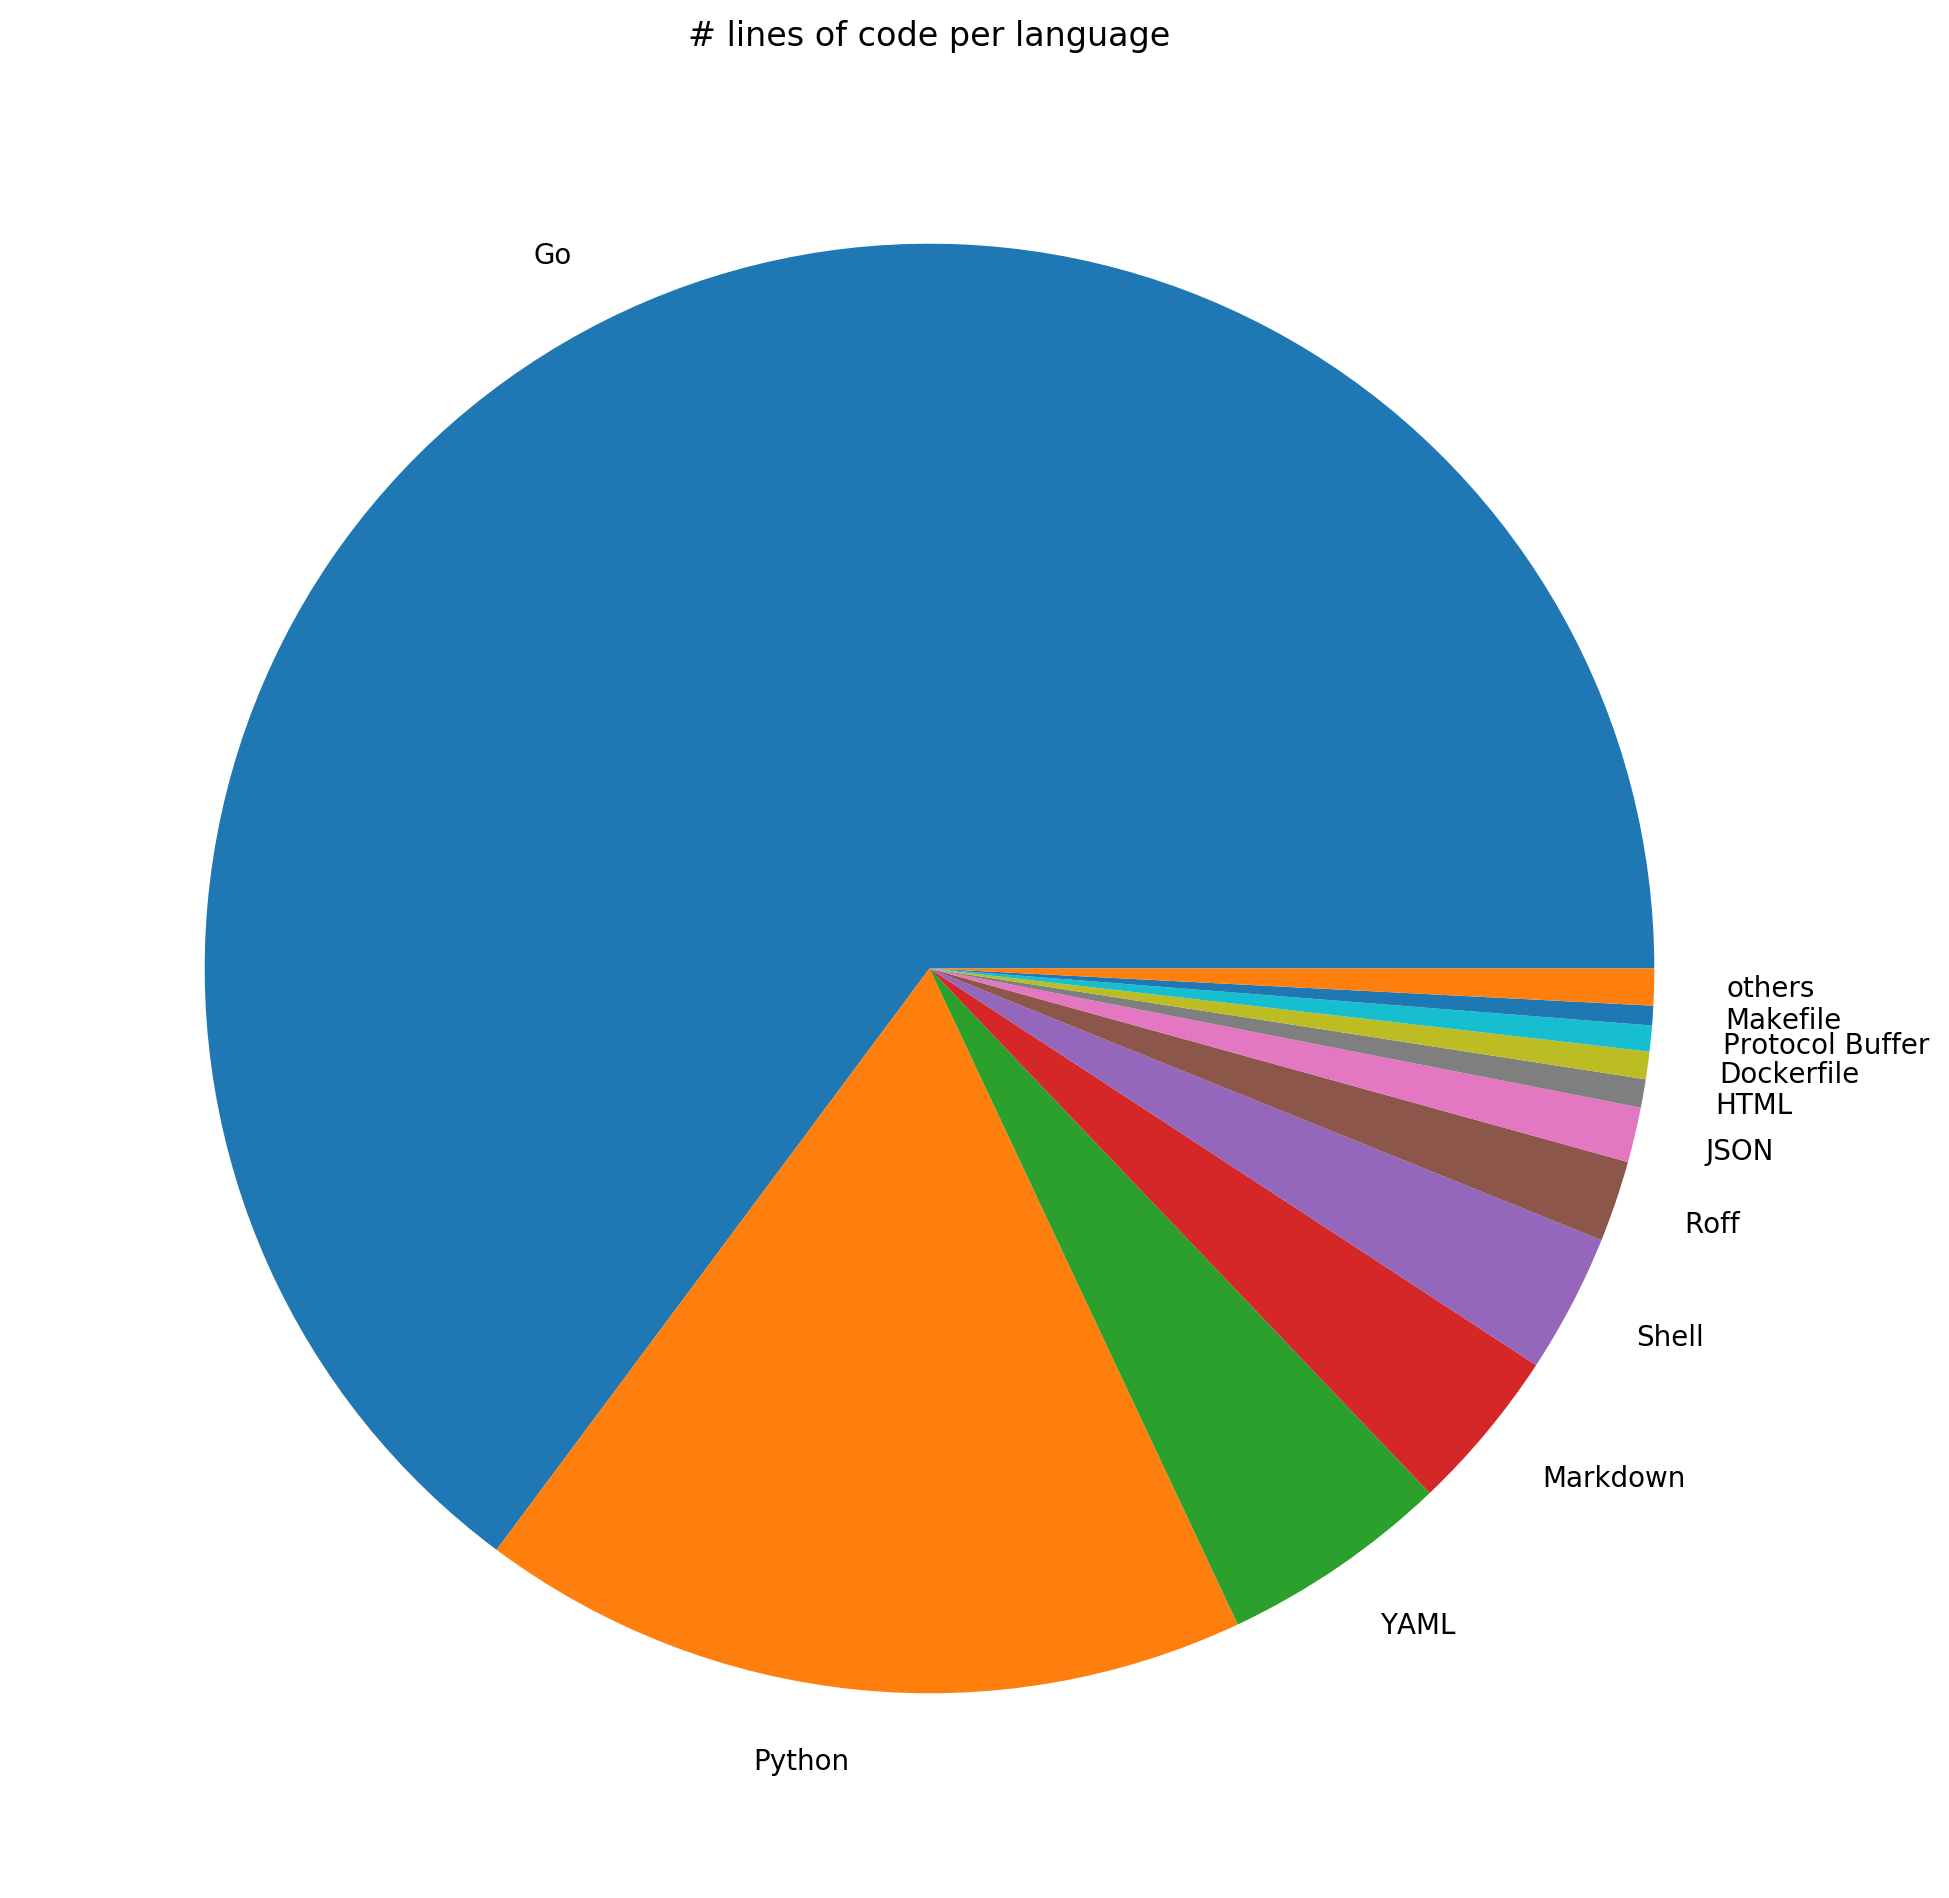

In [320]:
percents = [(100*c)/sum(counts) for c in counts if c/sum(counts) > 0.004]
if len(percents) < len(langs):
    percents.append(100 - sum(percents))
    langs = langs[:len(percents)-1] + ('others',)

plt.figure(figsize=(12,12), dpi=200)
plt.title('# lines of code per language')
plt.pie(percents, labels=langs)
plt.show()

What was this proportion over time? Have we always had so much Go?

In [208]:
def count_langs_in_commit(commit):
    (trees,) = zip(*run('''
    SELECT tree_hash
    FROM commit_trees
    WHERE commit_hash='%s'
    ''' % commit, log=False))

    (langs, lang_files,) = zip(*run('''
    SELECT LANGUAGE(file_path, blob_content) as lang, COUNT(*)
    FROM files
    WHERE repository_id = 'kubernetes'
      AND tree_entry_mode != 40000
      AND file_path NOT LIKE 'vendor/%%'
      AND file_path NOT LIKE 'Godeps/%%'
      AND file_path NOT LIKE 'third_party/%%'
      AND file_path NOT LIKE '%%/internal/%%'           
      AND tree_hash in (%s)
    GROUP BY lang
    ''' % ', '.join(['"%s"' % x for x in trees]), log=False))

    return {l: f for (l, f) in zip(langs,lang_files)}

In [209]:
indexes = list(range(0, len(commits), 1000))
lang_counts = Parallel(n_jobs=96, verbose=10)(
    delayed(count_langs_in_commit)(commits[i]) for i in indexes)

[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   2 out of  73 | elapsed:  2.5min remaining: 88.3min
[Parallel(n_jobs=96)]: Done  10 out of  73 | elapsed:  2.9min remaining: 18.3min
[Parallel(n_jobs=96)]: Done  18 out of  73 | elapsed:  3.0min remaining:  9.2min
[Parallel(n_jobs=96)]: Done  26 out of  73 | elapsed:  3.0min remaining:  5.5min
[Parallel(n_jobs=96)]: Done  34 out of  73 | elapsed:  3.0min remaining:  3.5min
[Parallel(n_jobs=96)]: Done  42 out of  73 | elapsed:  3.1min remaining:  2.3min
[Parallel(n_jobs=96)]: Done  50 out of  73 | elapsed:  3.1min remaining:  1.4min
[Parallel(n_jobs=96)]: Done  58 out of  73 | elapsed:  3.1min remaining:   47.9s
[Parallel(n_jobs=96)]: Done  66 out of  73 | elapsed:  3.1min remaining:   19.7s
[Parallel(n_jobs=96)]: Done  73 out of  73 | elapsed:  3.1min finished


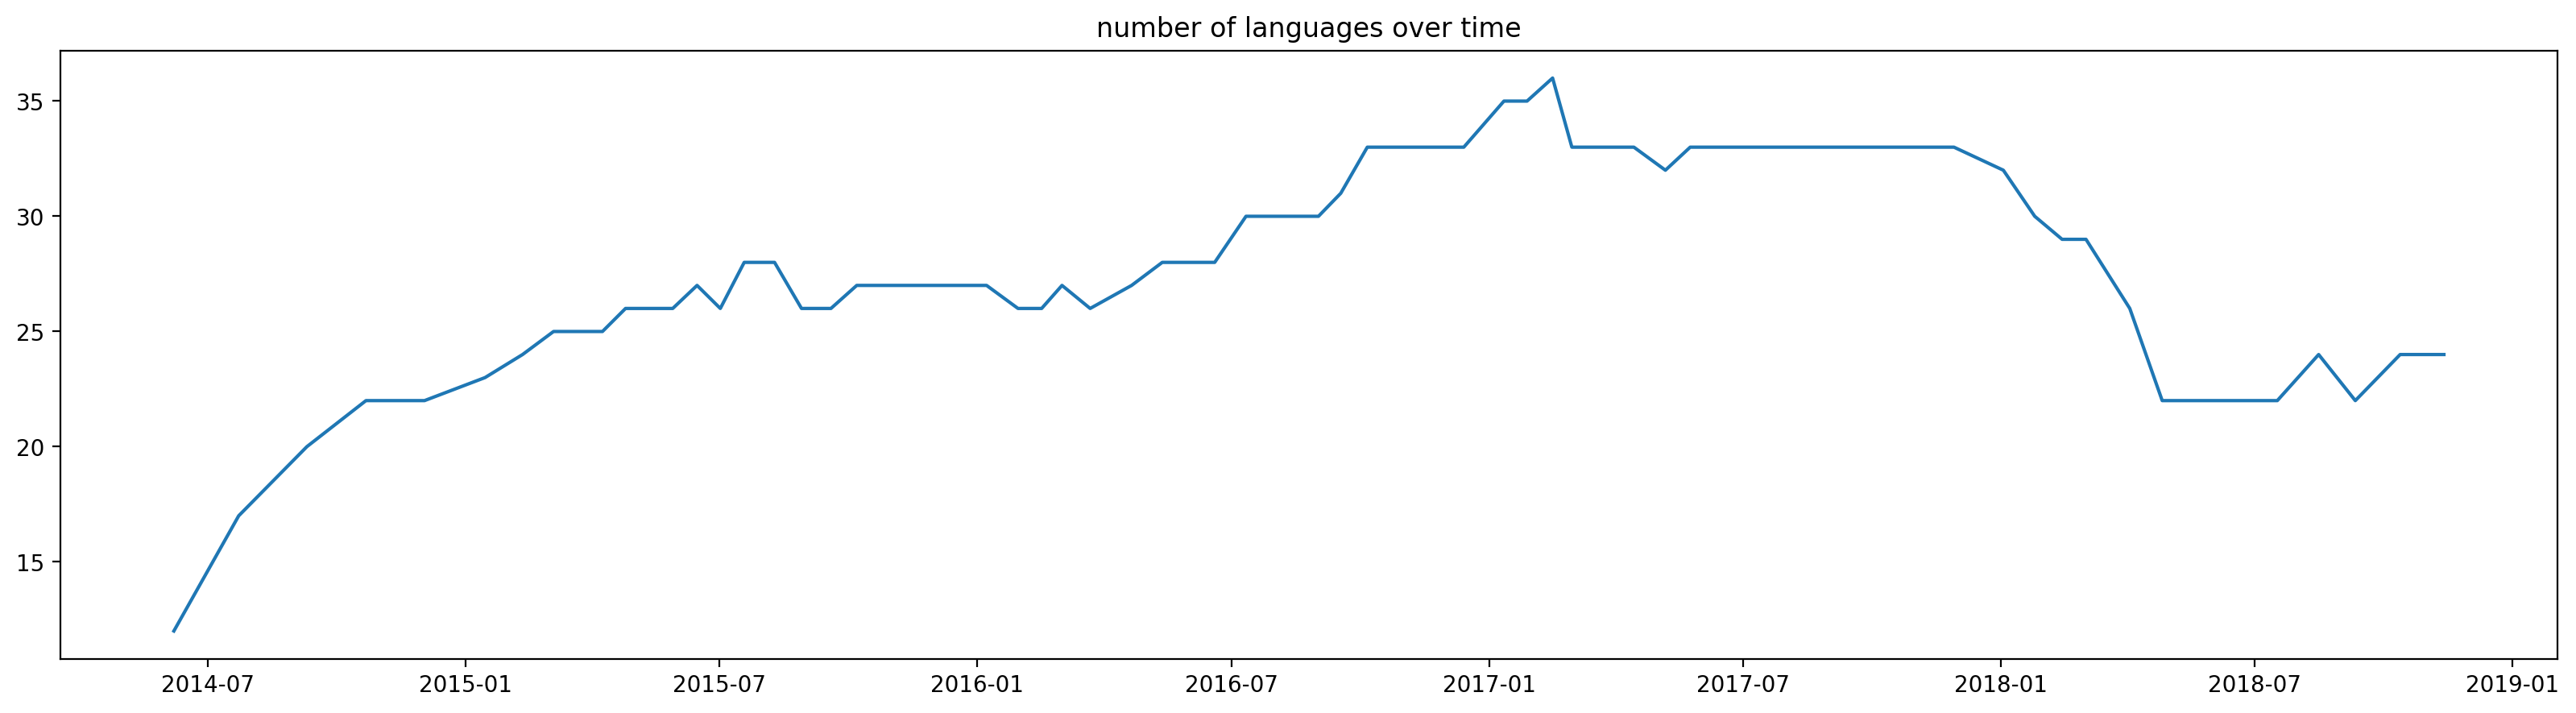

In [210]:
(ts, ls) = zip(*[(timestamps[idx], len(lang_counts[i])) for (i, idx) in enumerate(indexes)])
plt.figure(figsize=(20,5), dpi=200)
plt.title('number of languages over time')
plt.plot(ts, ls)
plt.show()

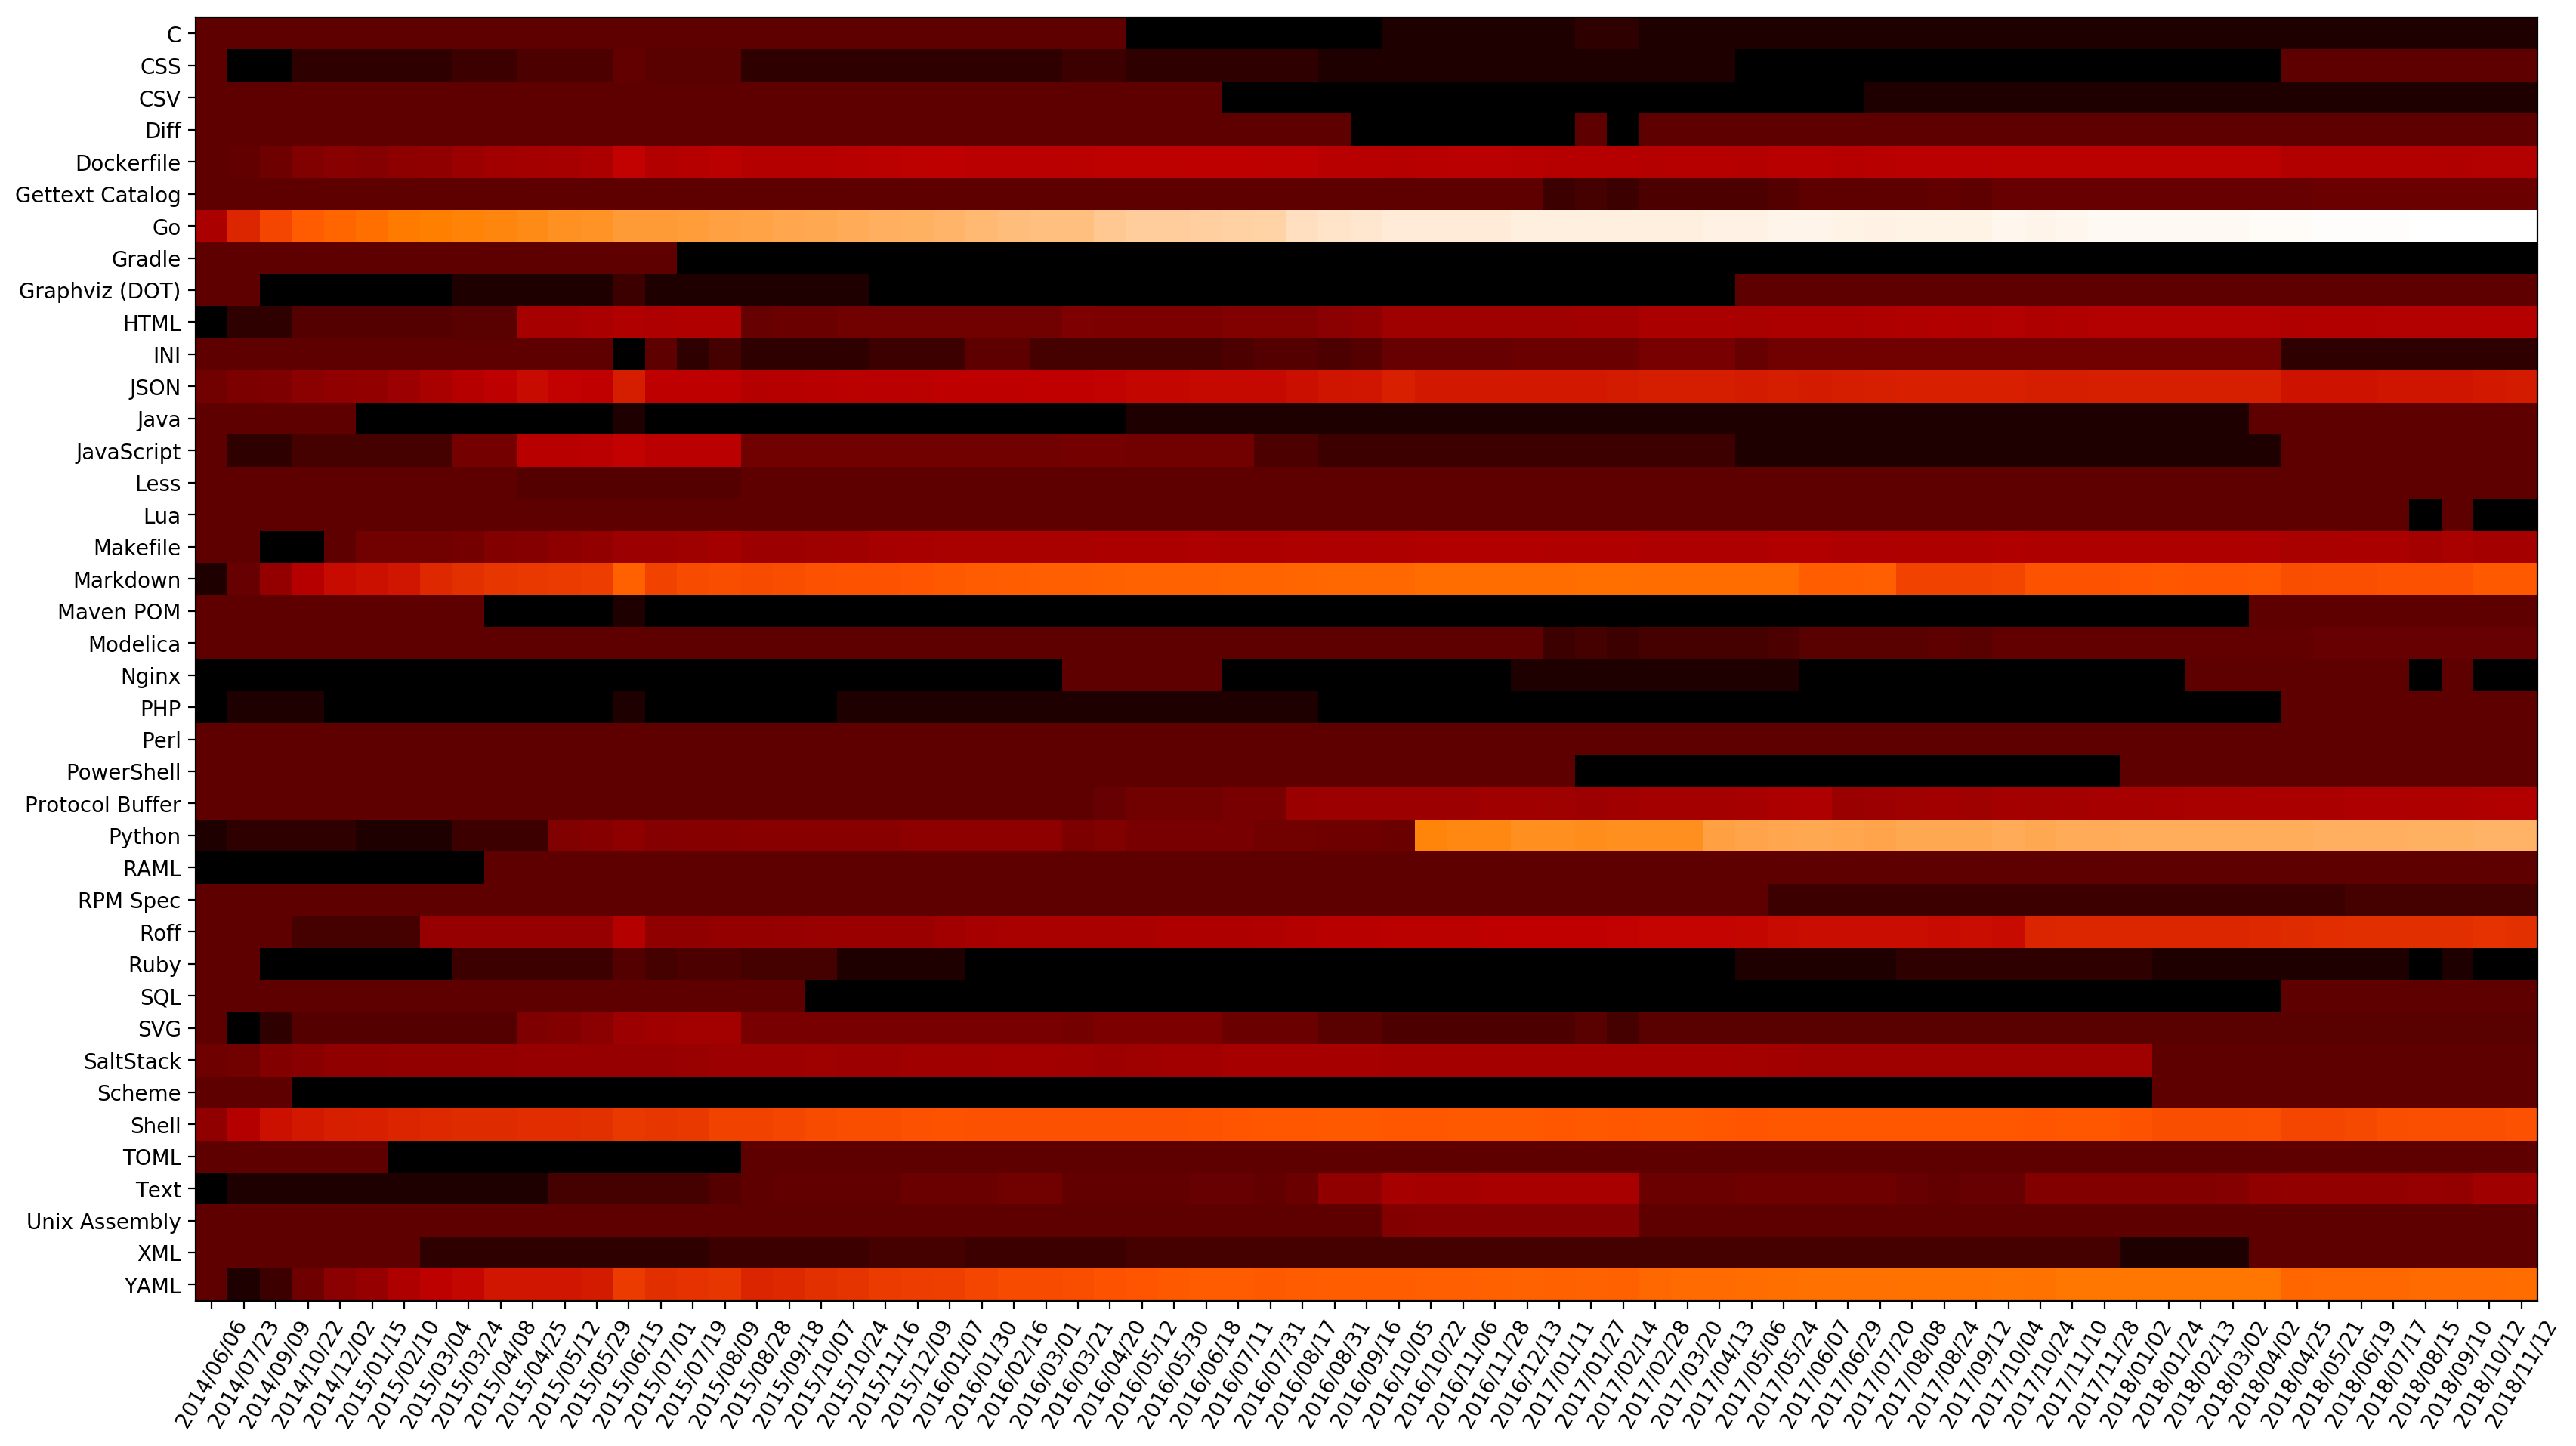

In [226]:
import matplotlib.dates as mdates

all_langs = sorted(list(set([k for v in lang_counts for k in v.keys() if k != ''])))
lang_mat = [[np.log(lang_count.get(l, 9))  for lang_count in lang_counts] for l in all_langs]

fig, ax = plt.subplots(figsize=(20,30), dpi=200)
ax.set_xticks(np.arange(len(indexes)))
ax.set_xticklabels([timestamps[i].strftime('%Y/%m/%d') for i in indexes])

plt.xticks(rotation=60)

ax.set_yticks(np.arange(len(all_langs)))
ax.set_yticklabels(all_langs)

im = ax.imshow(lang_mat, cmap='gist_heat')

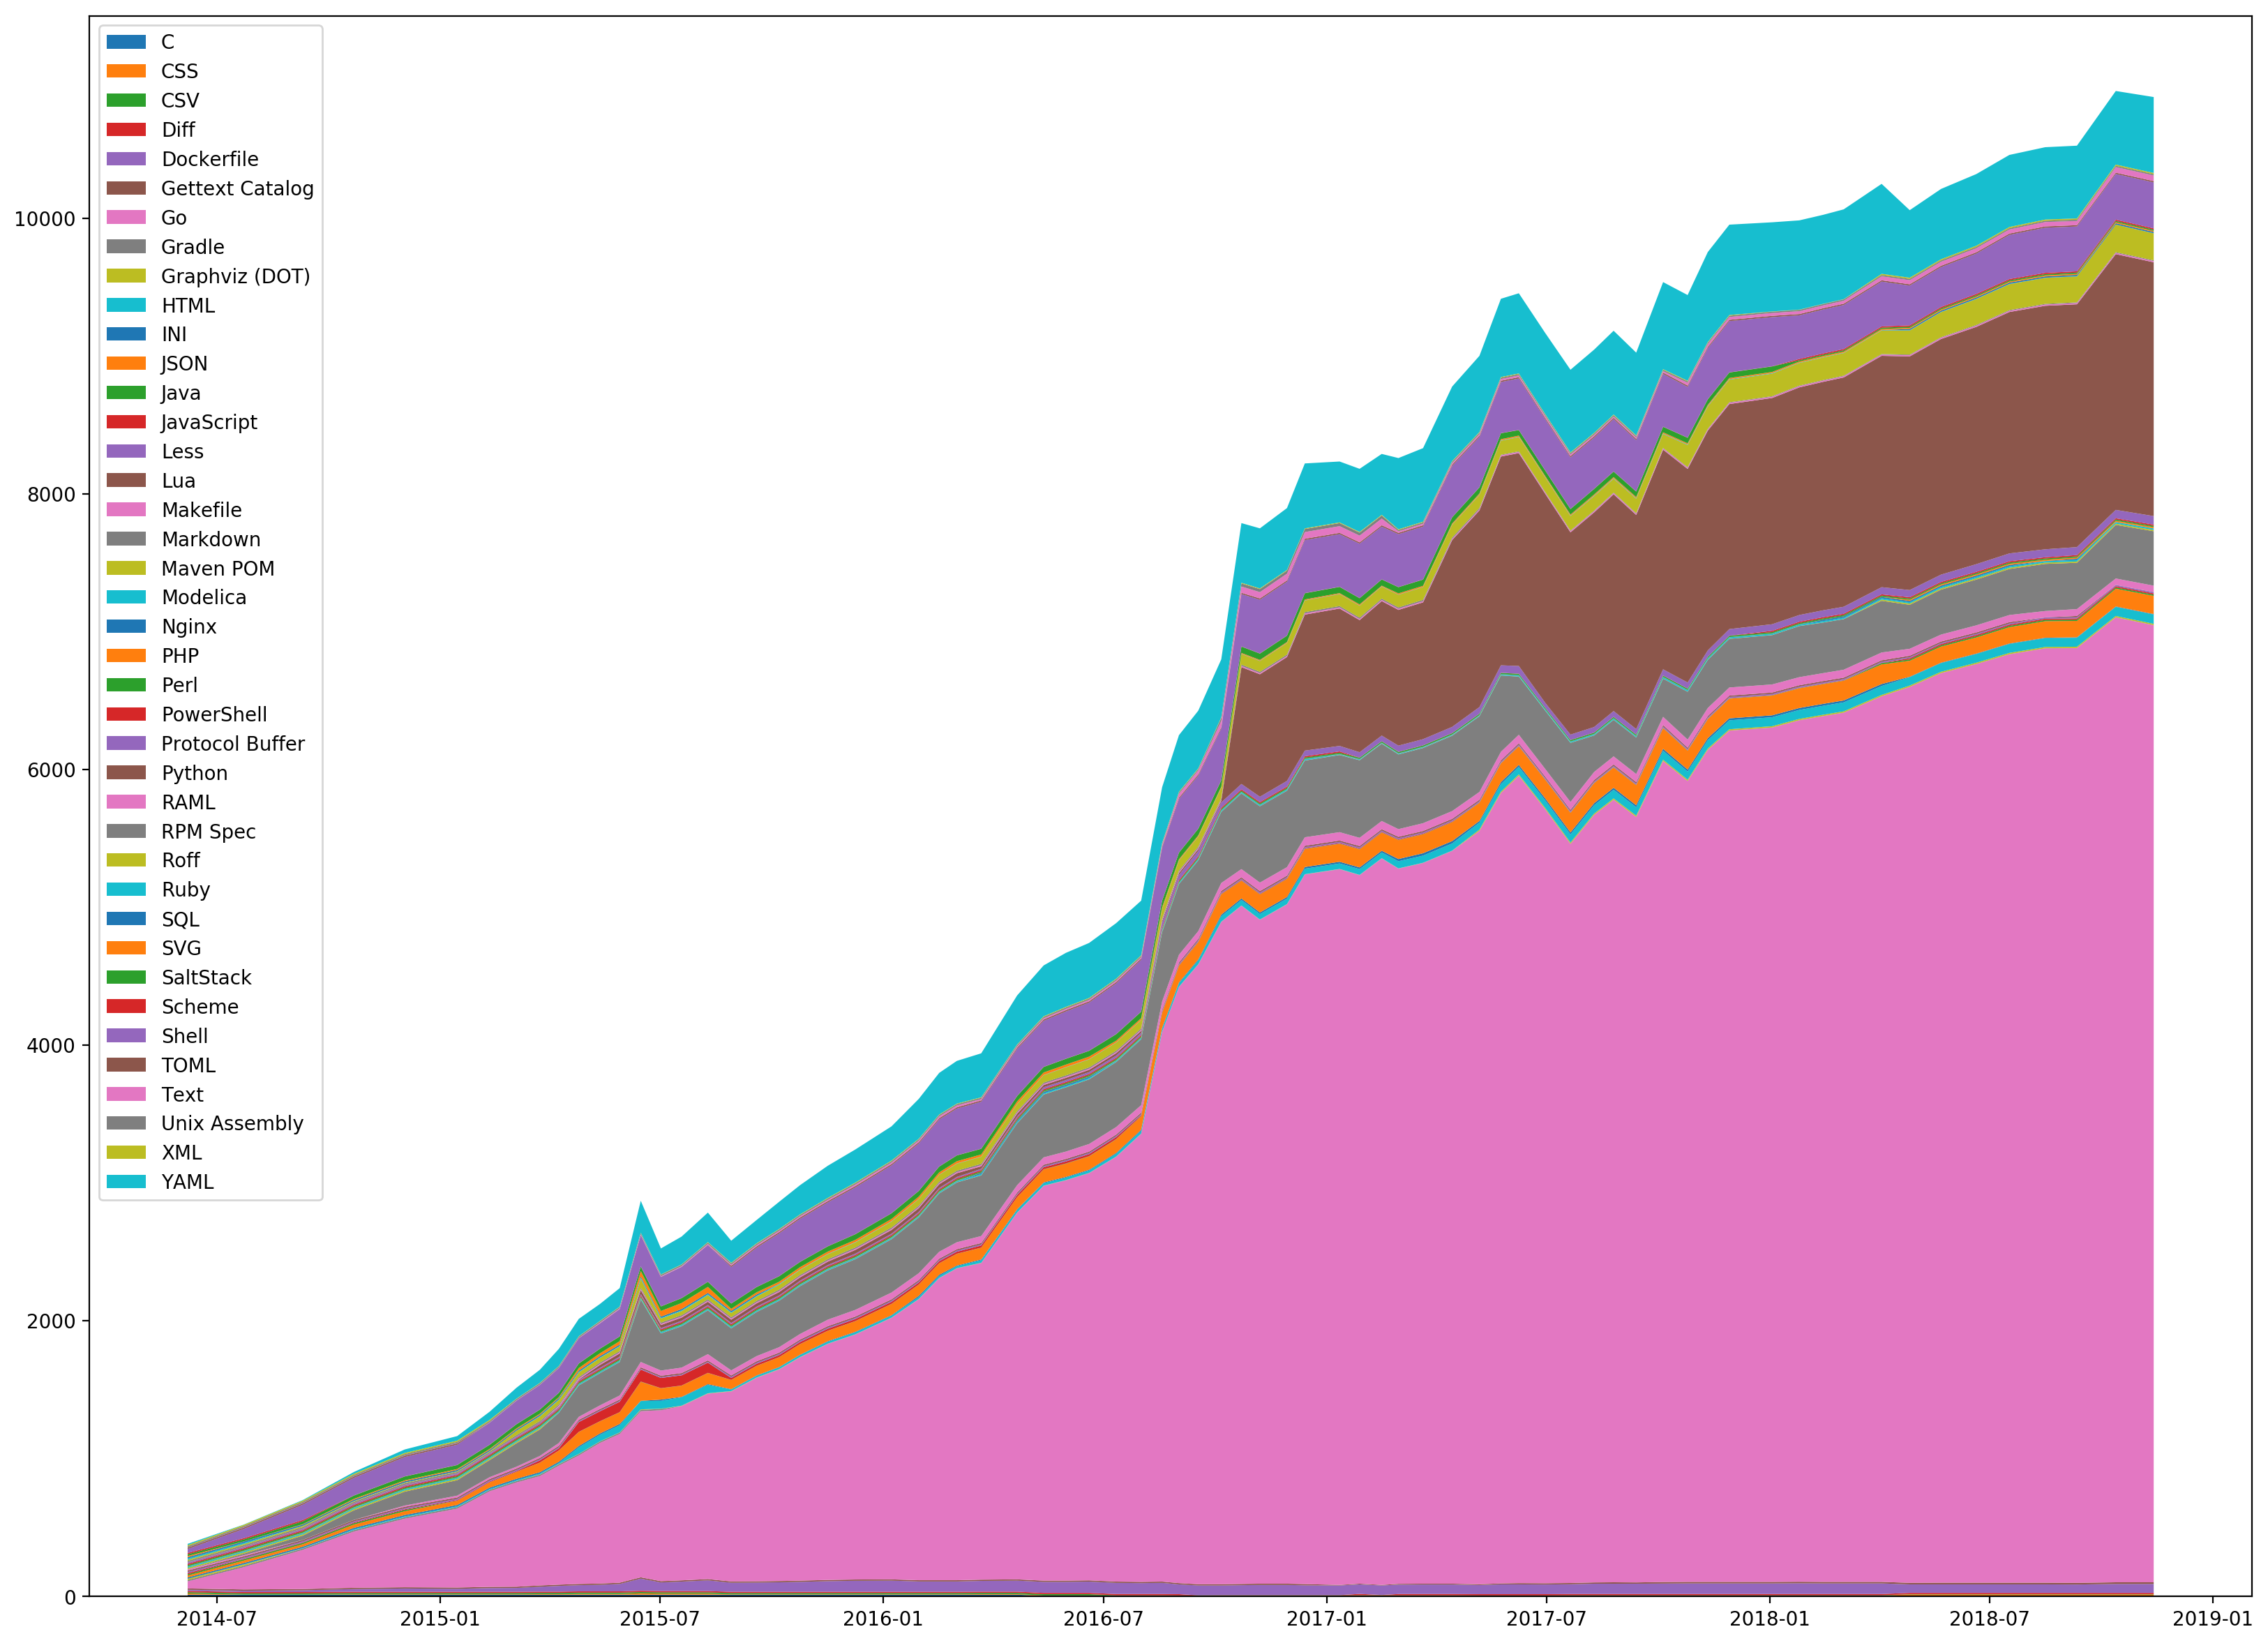

In [227]:
import operator

excluded = ['']
exclude_top = 0
if exclude_top > 0:
    excluded += [l for (l, n) in sorted(lang_counts[-1].items(), key=operator.itemgetter(1))[-exclude_top:] if l != '']
    print('excluding: %s' % ', '.join(excluded))

all_langs = sorted(list(set([k for v in lang_counts for k in v.keys() if k not in excluded])))
lang_nums = [[c.get(l, 9) for c in lang_counts] for l in all_langs]

fig, ax = plt.subplots(figsize=(20,15), dpi=200)
ax.stackplot(ts, *lang_nums, labels=all_langs)
ax.legend(all_langs, loc='upper left')
plt.show()

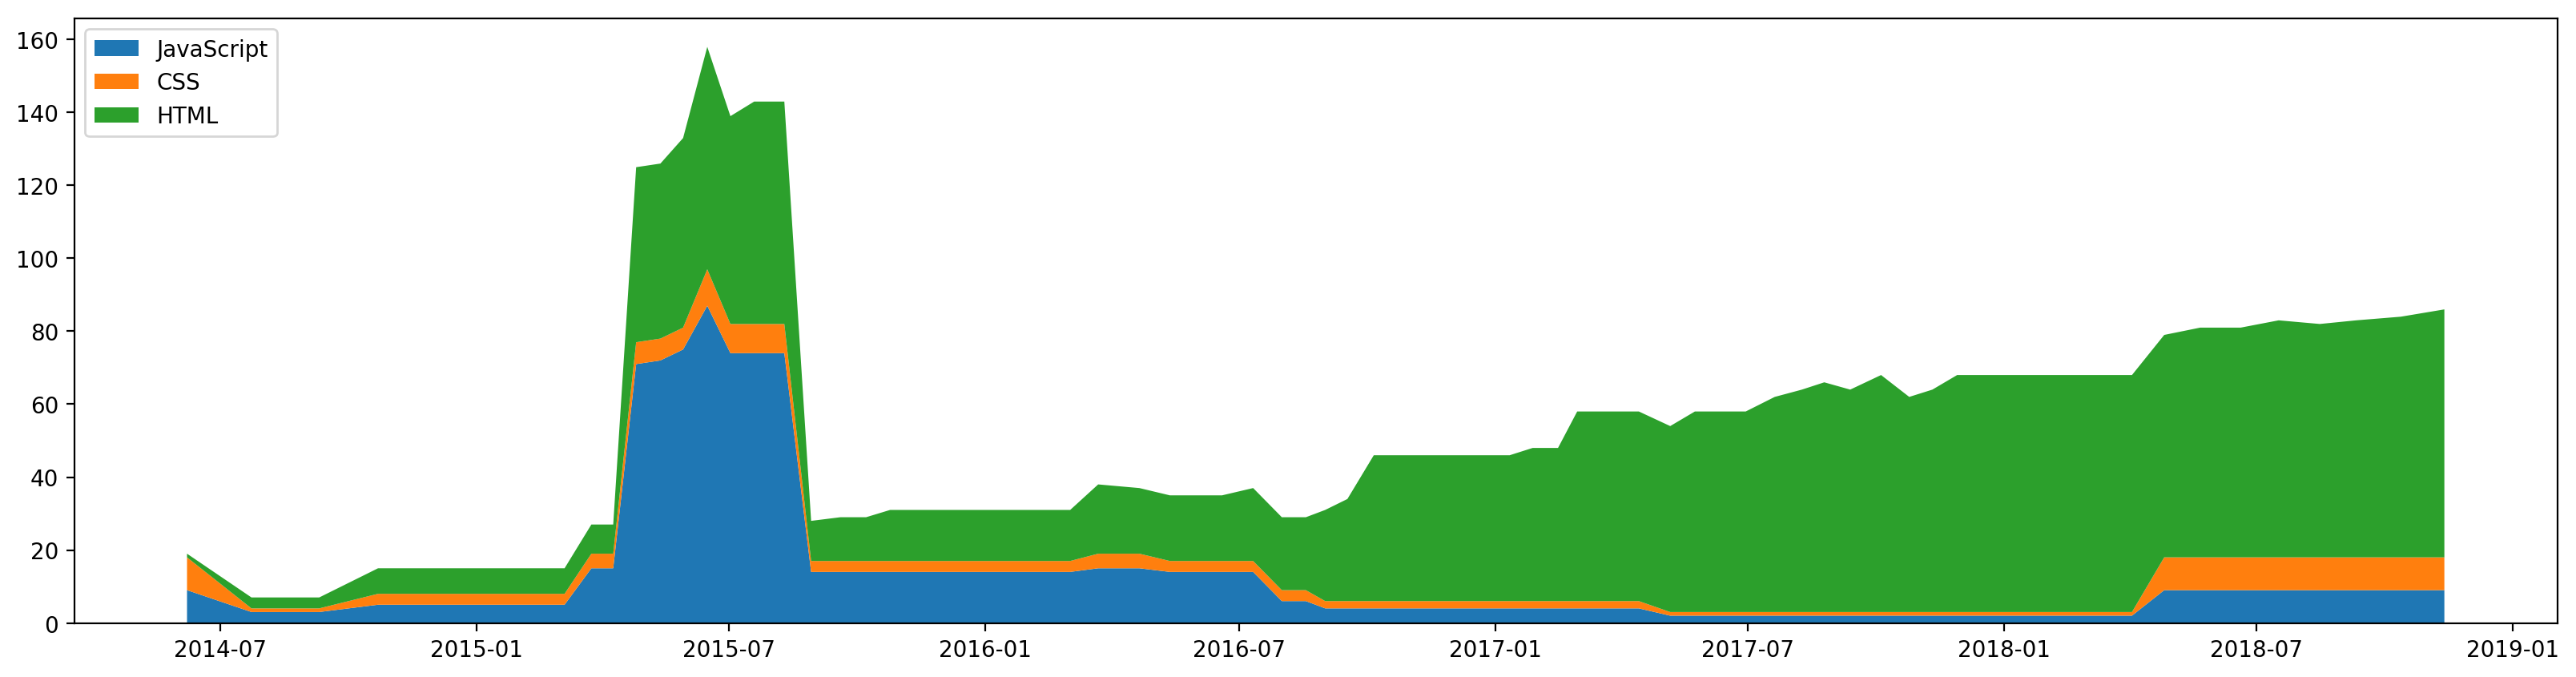

In [228]:
all_langs = ['JavaScript', 'CSS', 'HTML']
lang_nums = [[c.get(l, 9) for c in lang_counts] for l in all_langs]

fig, ax = plt.subplots(figsize=(20,5), dpi=200)
ax.stackplot(ts, *lang_nums, labels=all_langs)
ax.legend(all_langs, loc='upper left')
plt.show()

In [229]:
def count_lines_per_langs_in_commit(commit):
    (trees,) = zip(*run('''
    SELECT tree_hash
    FROM commit_trees
    WHERE commit_hash='%s'
    ''' % commit, log=False))

    (langs, lang_lines,) = zip(*run('''
    SELECT LANGUAGE(file_path, blob_content) as lang, SUM(ARRAY_LENGTH(SPLIT(blob_content, '\n'))) as n
    FROM files
    WHERE repository_id = 'kubernetes'
      AND tree_entry_mode != 40000
      AND tree_hash in (%s)
    GROUP BY lang
    ''' % ', '.join(['"%s"' % x for x in trees]), log=False))

    return {l: f for (l, f) in zip(langs, lang_lines)}

In [230]:
lang_lines = Parallel(n_jobs=-1, verbose=10)(
    delayed(count_lines_per_langs_in_commit)(commits[i]) for i in indexes)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  73 | elapsed:  2.5min remaining: 89.8min
[Parallel(n_jobs=-1)]: Done  10 out of  73 | elapsed:  2.7min remaining: 17.1min
[Parallel(n_jobs=-1)]: Done  18 out of  73 | elapsed:  2.7min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done  26 out of  73 | elapsed:  2.8min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  34 out of  73 | elapsed:  3.0min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  42 out of  73 | elapsed:  3.0min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:  3.0min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:  3.0min remaining:   46.9s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:  3.0min remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:  3.0min finished


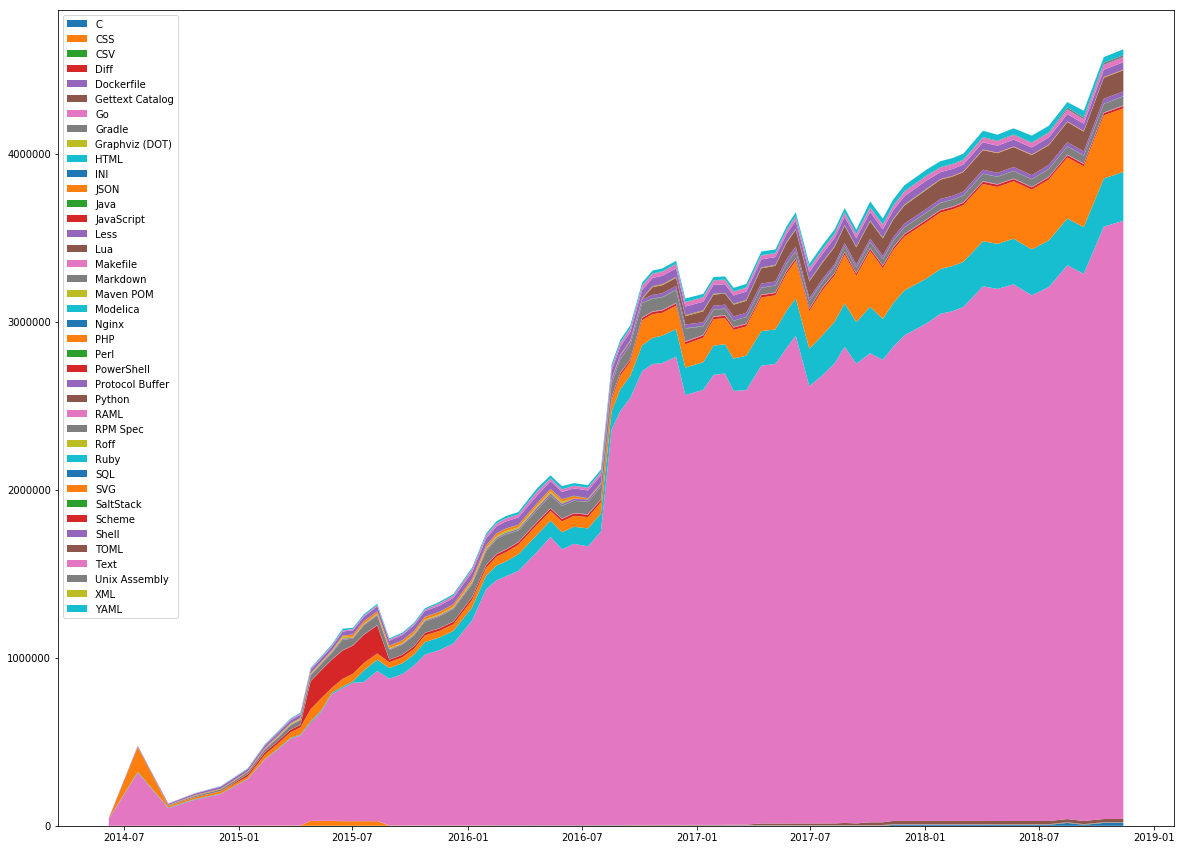

In [255]:
import operator

all_langs = sorted(list(set([k for v in lang_counts for k in v.keys() if k != ''])))
lang_nums = [[c.get(l, 0) for c in lang_lines] for l in all_langs]

fig, ax = plt.subplots(figsize=(20,15))
ax.stackplot(ts, *lang_nums, labels=all_langs)
ax.legend(all_langs, loc='upper left')
plt.show()

There's a very interesting bump around July 2015, can you see it?
According to the colors it corresponds to some `JavaScript` language ... let's investigate!

Let's remove the biggest ones.

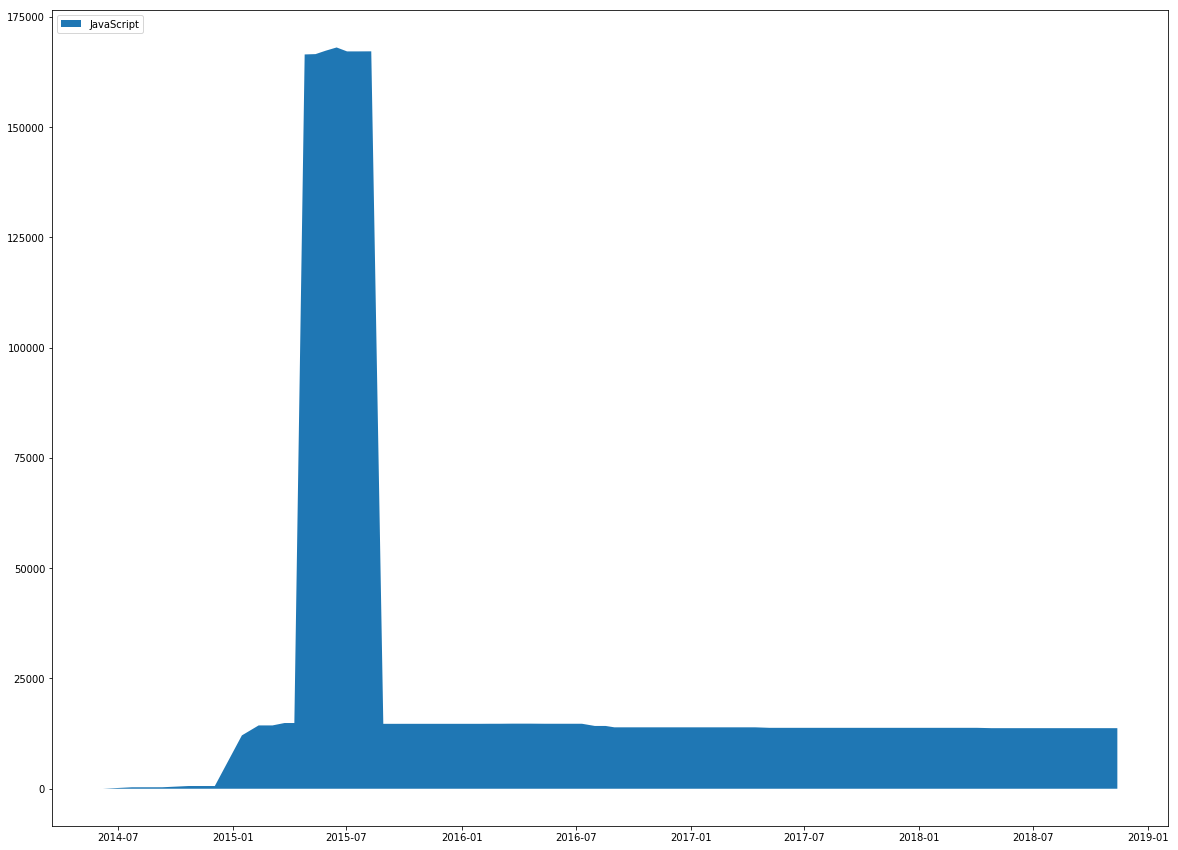

In [254]:
import operator

web_langs = ['JavaScript']
lang_nums = [[c.get(l, 0) for c in lang_lines] for l in web_langs]

fig, ax = plt.subplots(figsize=(20,15))
ax.stackplot(ts, *lang_nums, labels=web_langs)
ax.legend(web_langs, loc='upper left')
plt.show()

And last but not least, what files tend to be longer?

In [ ]:
langs, files, lines = zip(*run("""
SELECT lang, files, lines
FROM (
    SELECT lang, COUNT(*) as files, SUM(lines) as lines
    FROM (
        SELECT f.repository_id, LANGUAGE(cf.file_path, f.blob_content) as lang,
               ARRAY_LENGTH(SPLIT(f.blob_content, '\n')) as lines
        FROM   files AS f
               NATURAL JOIN commit_files cf
               NATURAL JOIN refs
        WHERE  ref_name = 'HEAD'
    ) AS t
    WHERE lang IS NOT NULL
    GROUP BY lang
) AS t
WHERE files > 10
ORDER BY lang
"""))

In [ ]:
rows = run("""
    SELECT lang, COUNT(*) as n, MIN(concat(repo, '/', path)) as path
    FROM (
        SELECT f.repository_id as repo, LANGUAGE(f.file_path, f.blob_content) as lang, f.file_path as path,
               ARRAY_LENGTH(SPLIT(f.blob_content, '\n')) as lines
        FROM   files AS f
               NATURAL JOIN commit_files cf
               NATURAL JOIN refs
        WHERE  ref_name = 'HEAD'
    ) AS t
    GROUP BY lang
    ORDER BY n
""")

In [ ]:
for row in rows:
  print(*row)

In [ ]:
fig, s = plt.subplots(figsize=(20,10))
s.scatter(files, lines)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('#files'); plt.ylabel('#lines')
for i, lang in enumerate(langs):
    s.annotate(lang, (files[i], lines[i]))

plt.title('#lines vs #files')
plt.show()

In [ ]:
import operator

l = list(zip(langs, lines, files, np.array(lines)/np.array(files)))
l.sort(key=operator.itemgetter(3))

headers = '%30s % 10s % 10s %10s'  % ('langs', 'lines', 'files', 'ratio')
headers = '\n' + headers + '\n' + '-' * len(headers)
template = '%30s % 10d % 10d % 10.2f'

print('languages with longer files:')
print(headers)
for r in l[:10]:
  print(template % r)

print('\nlanguages with shorter files:')
print(headers)
for r in l[-10:]:
  print(template % r)


Those 46 Perl 6 files containing over 65k lines of code has to be a fun place to work!

## Parsing and extracting from source code

After understanding the `LANGUAGE` function it's time to present `UAST`. This function receives two parameters:
- the language to be parsed
- the content of the file to be parsed

Let's give it a try and parse some of the files.

In [256]:
(release_name, release_commits, release_timestamps) = zip(*run('''
SELECT ref_name, commit_hash, commit_author_when
FROM refs
NATURAL JOIN commits
WHERE repository_id = 'kubernetes'
  AND ref_name LIKE '%release%'
ORDER BY commit_author_when
'''))

2018-12-06 01:20:50 instance-4 root[5533] INFO done in 0.63 seconds


In [257]:
import json
import os

def find_exported_functions_in_commit(commit):
    (trees,) = zip(*run('''
    SELECT tree_hash
    FROM commit_trees
    WHERE commit_hash='%s'
    ''' % commit, log=True))

    (paths, funcs) = zip(*run('''
    SELECT file_path,
           UAST_EXTRACT(UAST(
             blob_content,
             LANGUAGE(file_path, blob_content),
             '//uast:FunctionGroup/*/uast:Alias/*/uast:Identifier'), 'Name')
     FROM files
     WHERE repository_id = 'kubernetes'
       AND tree_entry_mode != 40000
       AND file_path NOT LIKE '%%_test.go'
       AND file_path NOT LIKE 'vendor/%%'
       AND file_path NOT LIKE 'Godeps/%%'
       AND file_path NOT LIKE 'third_party/%%'
       AND file_path NOT LIKE '%%/internal/%%'
       AND tree_hash in (%s)
       AND LANGUAGE(file_path, blob_content) = "Go"
    ''' % ', '.join(['"%s"' % x for x in trees]), log=True))

    parsed = [(p, json.loads(f)) for (p, f) in zip(paths, funcs) if f != 'null']
    names = []
    for (p, fs) in parsed:
        names.extend([(p, f) for f in fs if f[0].isupper()])
    return [(os.path.dirname(p), f) for (p, f) in names]

In [258]:
api_count = Parallel(n_jobs=-1, verbose=20)(
    delayed(find_exported_functions_in_commit)(commits[i]) for i in indexes)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 out of  73 | elapsed:  1.4min remaining: 48.3min
[Parallel(n_jobs=-1)]: Done   6 out of  73 | elapsed:  1.9min remaining: 21.5min
[Parallel(n_jobs=-1)]: Done  10 out of  73 | elapsed:  2.9min remaining: 18.5min
[Parallel(n_jobs=-1)]: Done  14 out of  73 | elapsed:  3.4min remaining: 14.1min
[Parallel(n_jobs=-1)]: Done  18 out of  73 | elapsed:  3.7min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done  22 out of  73 | elapsed:  4.7min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done  26 out of  73 | elapsed:  5.3min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done  30 out of  73 | elapsed:  6.1min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  34 out of  73 | elapsed:  6.3min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  38 out of  73 | elapsed:  8.2min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  42 out of  73 | elapse

In [259]:
# let's store this for later ...
# (this run includes also test, vendor, and godeps that's why it's *so* slow

len(api_count)
np.save('api_counts.npy', api_count)

In [36]:
loaded = np.load('api_counts.npy')

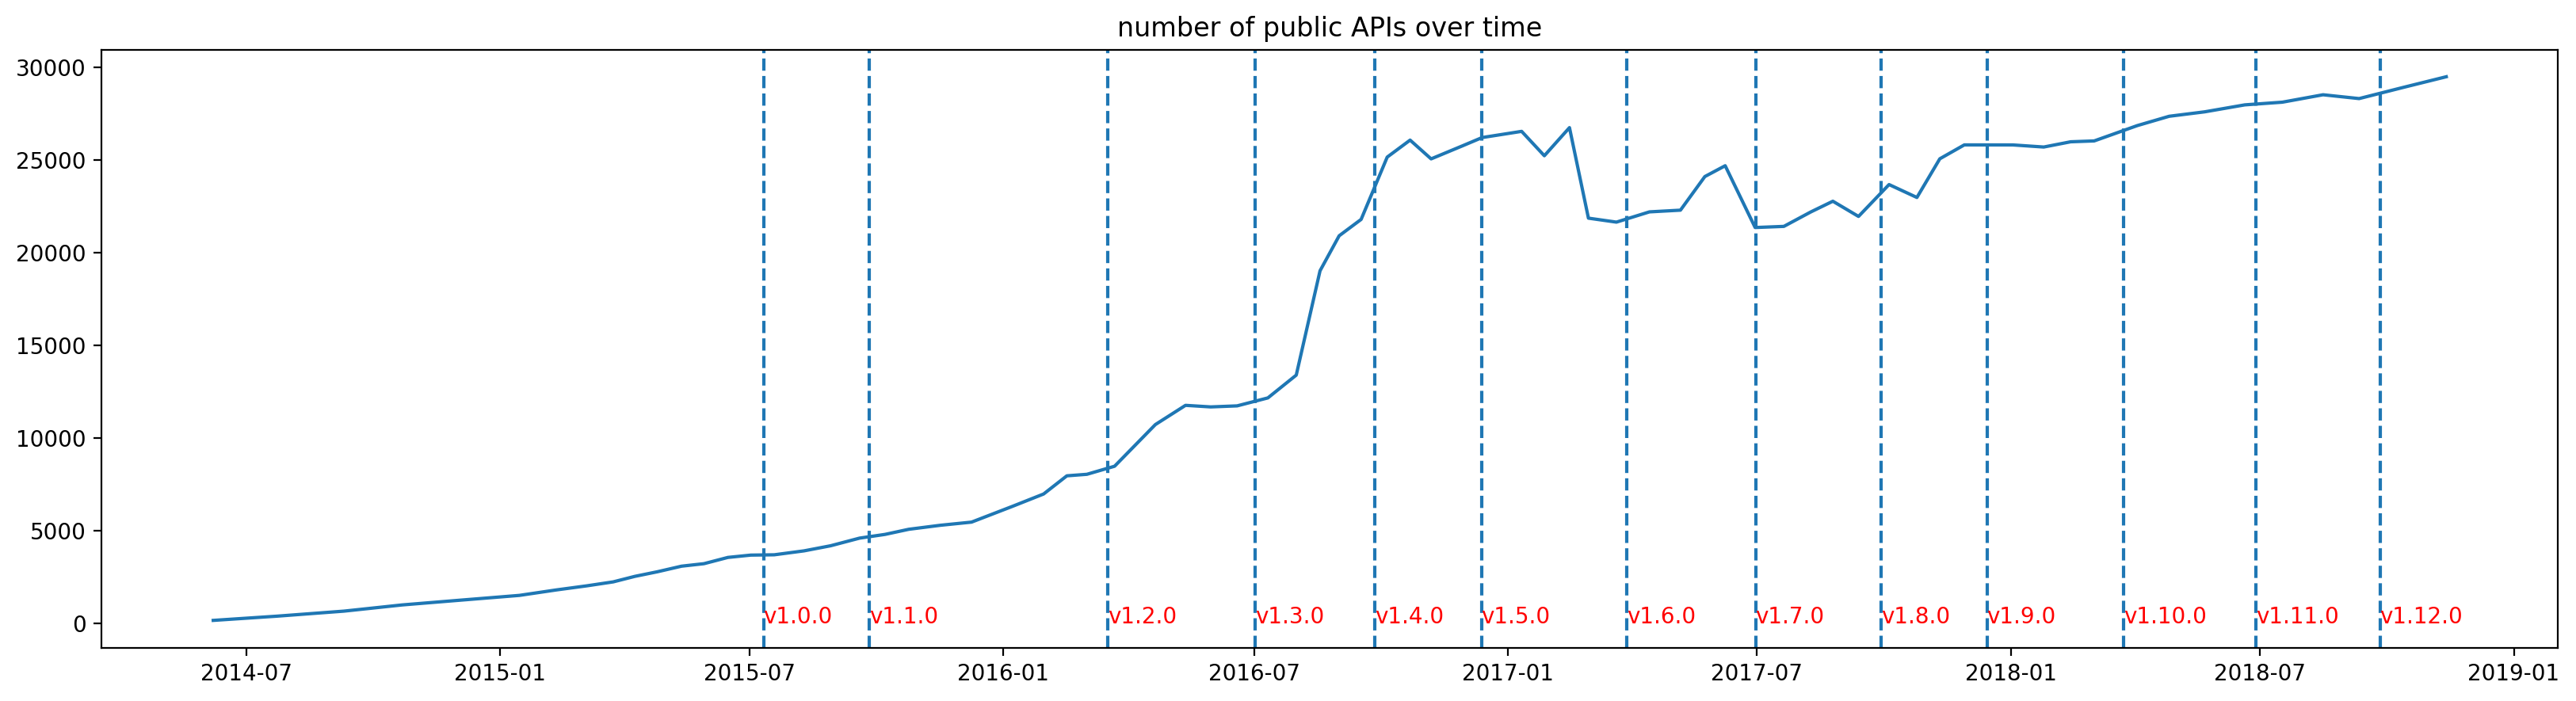

In [277]:
plt.figure(figsize=(20,5), dpi=200)
plt.title('number of public APIs over time')
labels = [timestamps[i] for i in indexes]
values = [len(c) for c in api_count]


# plt.scatter(labels, values, s=100, facecolor='w', edgecolor='k', zorder=9999)
plt.plot(labels, values)

(ts, ns) = zip(*[
    (t, n) for (t, n)
    in zip(release_timestamps, release_names)
    if n[1]=='1'])

for (i, ts) in enumerate(ts):
    plt.axvline(ts, linestyle='--')
    plt.text(ts, 0, ns[i], color='red')

plt.show()

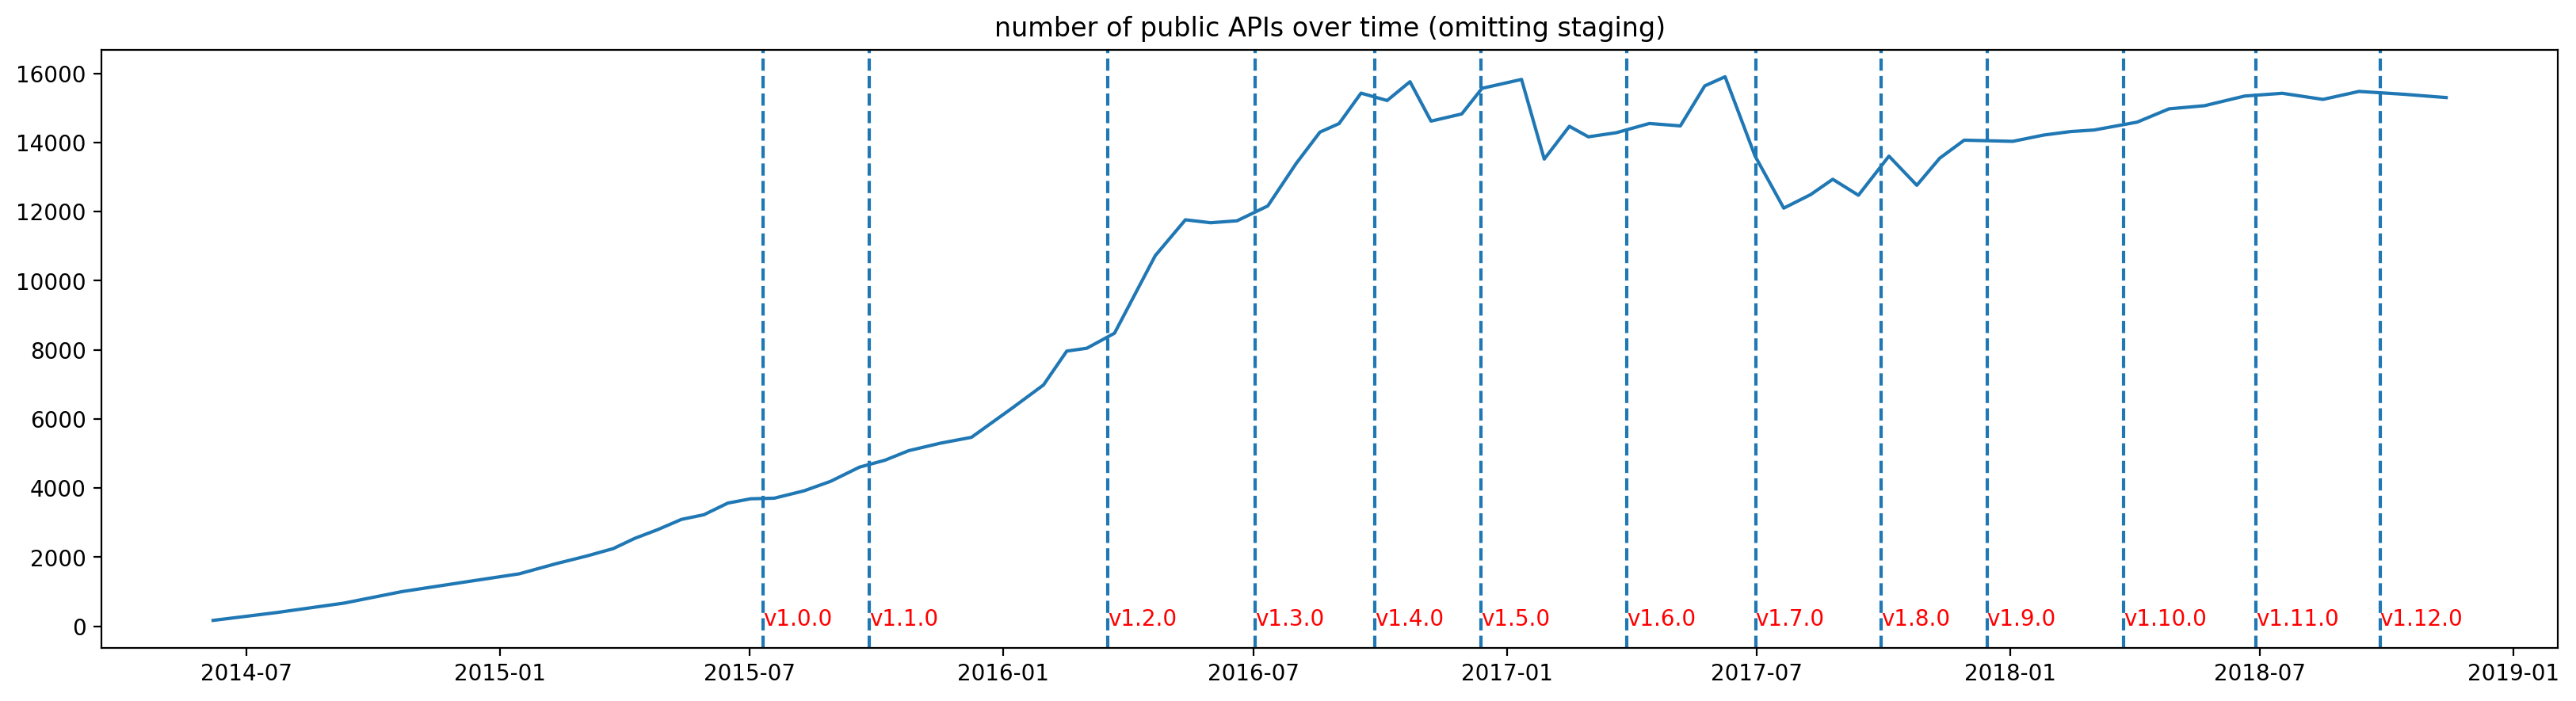

In [297]:
# what if we remove staging?

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of public APIs over time (omitting staging)')
labels = [timestamps[i] for i in indexes]
values = [len([1 for (f, n) in c if 'staging' not in f]) for c in api_count]
plt.plot(labels, values)

(ts, ns) = zip(*[
    (t, n) for (t, n)
    in zip(release_timestamps, release_names)
    if n[1]=='1'])

for (i, ts) in enumerate(ts):
    plt.axvline(ts, linestyle='--')
    plt.text(ts, 10, ns[i], color='red')

plt.show()

In [77]:
# methods that disappeared from 1.5 to 1.6

gone = list(set(api_count[versions.index('1.5')]) - set(api_count[versions.index('1.6')]))
print('found %d methods that disappeared from 1.5 to 1.6' % len(gone))
print('first 10 ones: \n\t%s' % '\n\t'.join(['%s.%s' % (p, f) for (p, f) in gone[:10]]))

found 7108 methods that disappeared from 1.5 to 1.6
first 10 ones: 
	staging/src/k8s.io/client-go/_vendor/golang.org/x/text/transform.Transform
	pkg/api/v1.Convert_api_NodeList_To_v1_NodeList
	pkg/genericapiserver/options.StorageGroupsToEncodingVersion
	staging/src/k8s.io/client-go/pkg/util.CreateTrie
	pkg/watch/versioned.Descriptor
	pkg/util/flag.Value
	pkg/httplog.Handler
	staging/src/k8s.io/client-go/pkg/util.LogIfLong
	pkg/util/cert.CanReadCertOrKey
	staging/src/k8s.io/client-go/_vendor/github.com/emicklei/go-restful.ReleaseGzipReader


In [92]:
pkgs15 = set([p for (p, f) in api_count[versions.index('1.5')]])
pkgs16 = set([p for (p, f) in api_count[versions.index('1.6')]])

pkgs_gone = pkgs16 - pkgs15
print('found %d packages that disappeared from 1.5 to 1.6' % len(pkgs_gone))
print('first 10 ones: \n\t%s' % '\n\t'.join(list(pkgs_gone)[:10]))

found 527 packages that disappeared from 1.5 to 1.6
first 10 ones: 
	staging/src/k8s.io/apimachinery/pkg/apis/meta/internalversion
	cmd/genslateyaml
	pkg/kubelet/gpu
	staging/src/k8s.io/client-go/kubernetes/typed/settings/v1alpha1
	pkg/client/clientset_generated/clientset/typed/autoscaling/v2alpha1
	pkg/printers/internalversion
	staging/src/k8s.io/apiserver/pkg/endpoints/filters
	staging/src/k8s.io/client-go/informers/autoscaling
	staging/src/k8s.io/client-go/pkg/apis/authentication/v1
	staging/src/k8s.io/client-go/informers/settings


In [94]:
len(pkgs16)

1131

In [88]:
list(set([p for p in pkgs_gone] if p[:p.index('/')] == 'pkg']))

SyntaxError: invalid syntax (<ipython-input-88-9834481064b0>, line 1)

## contributor analysis

What organizations have contributed the most to Kubernetes?

In [282]:
orgs, counts = zip(*run('''
SELECT JSON_EXTRACT(SPLIT(committer_email, '@'), '$[1]') as domain, COUNT(*) as n
FROM commits
WHERE repository_id = 'kubernetes'
  AND committer_email LIKE '%%@%%'
GROUP BY domain
ORDER BY n DESC
'''))

orgs = [o.strip('""') for o in orgs]

2018-12-06 01:41:23 instance-4 root[5533] INFO done in 16.87 seconds


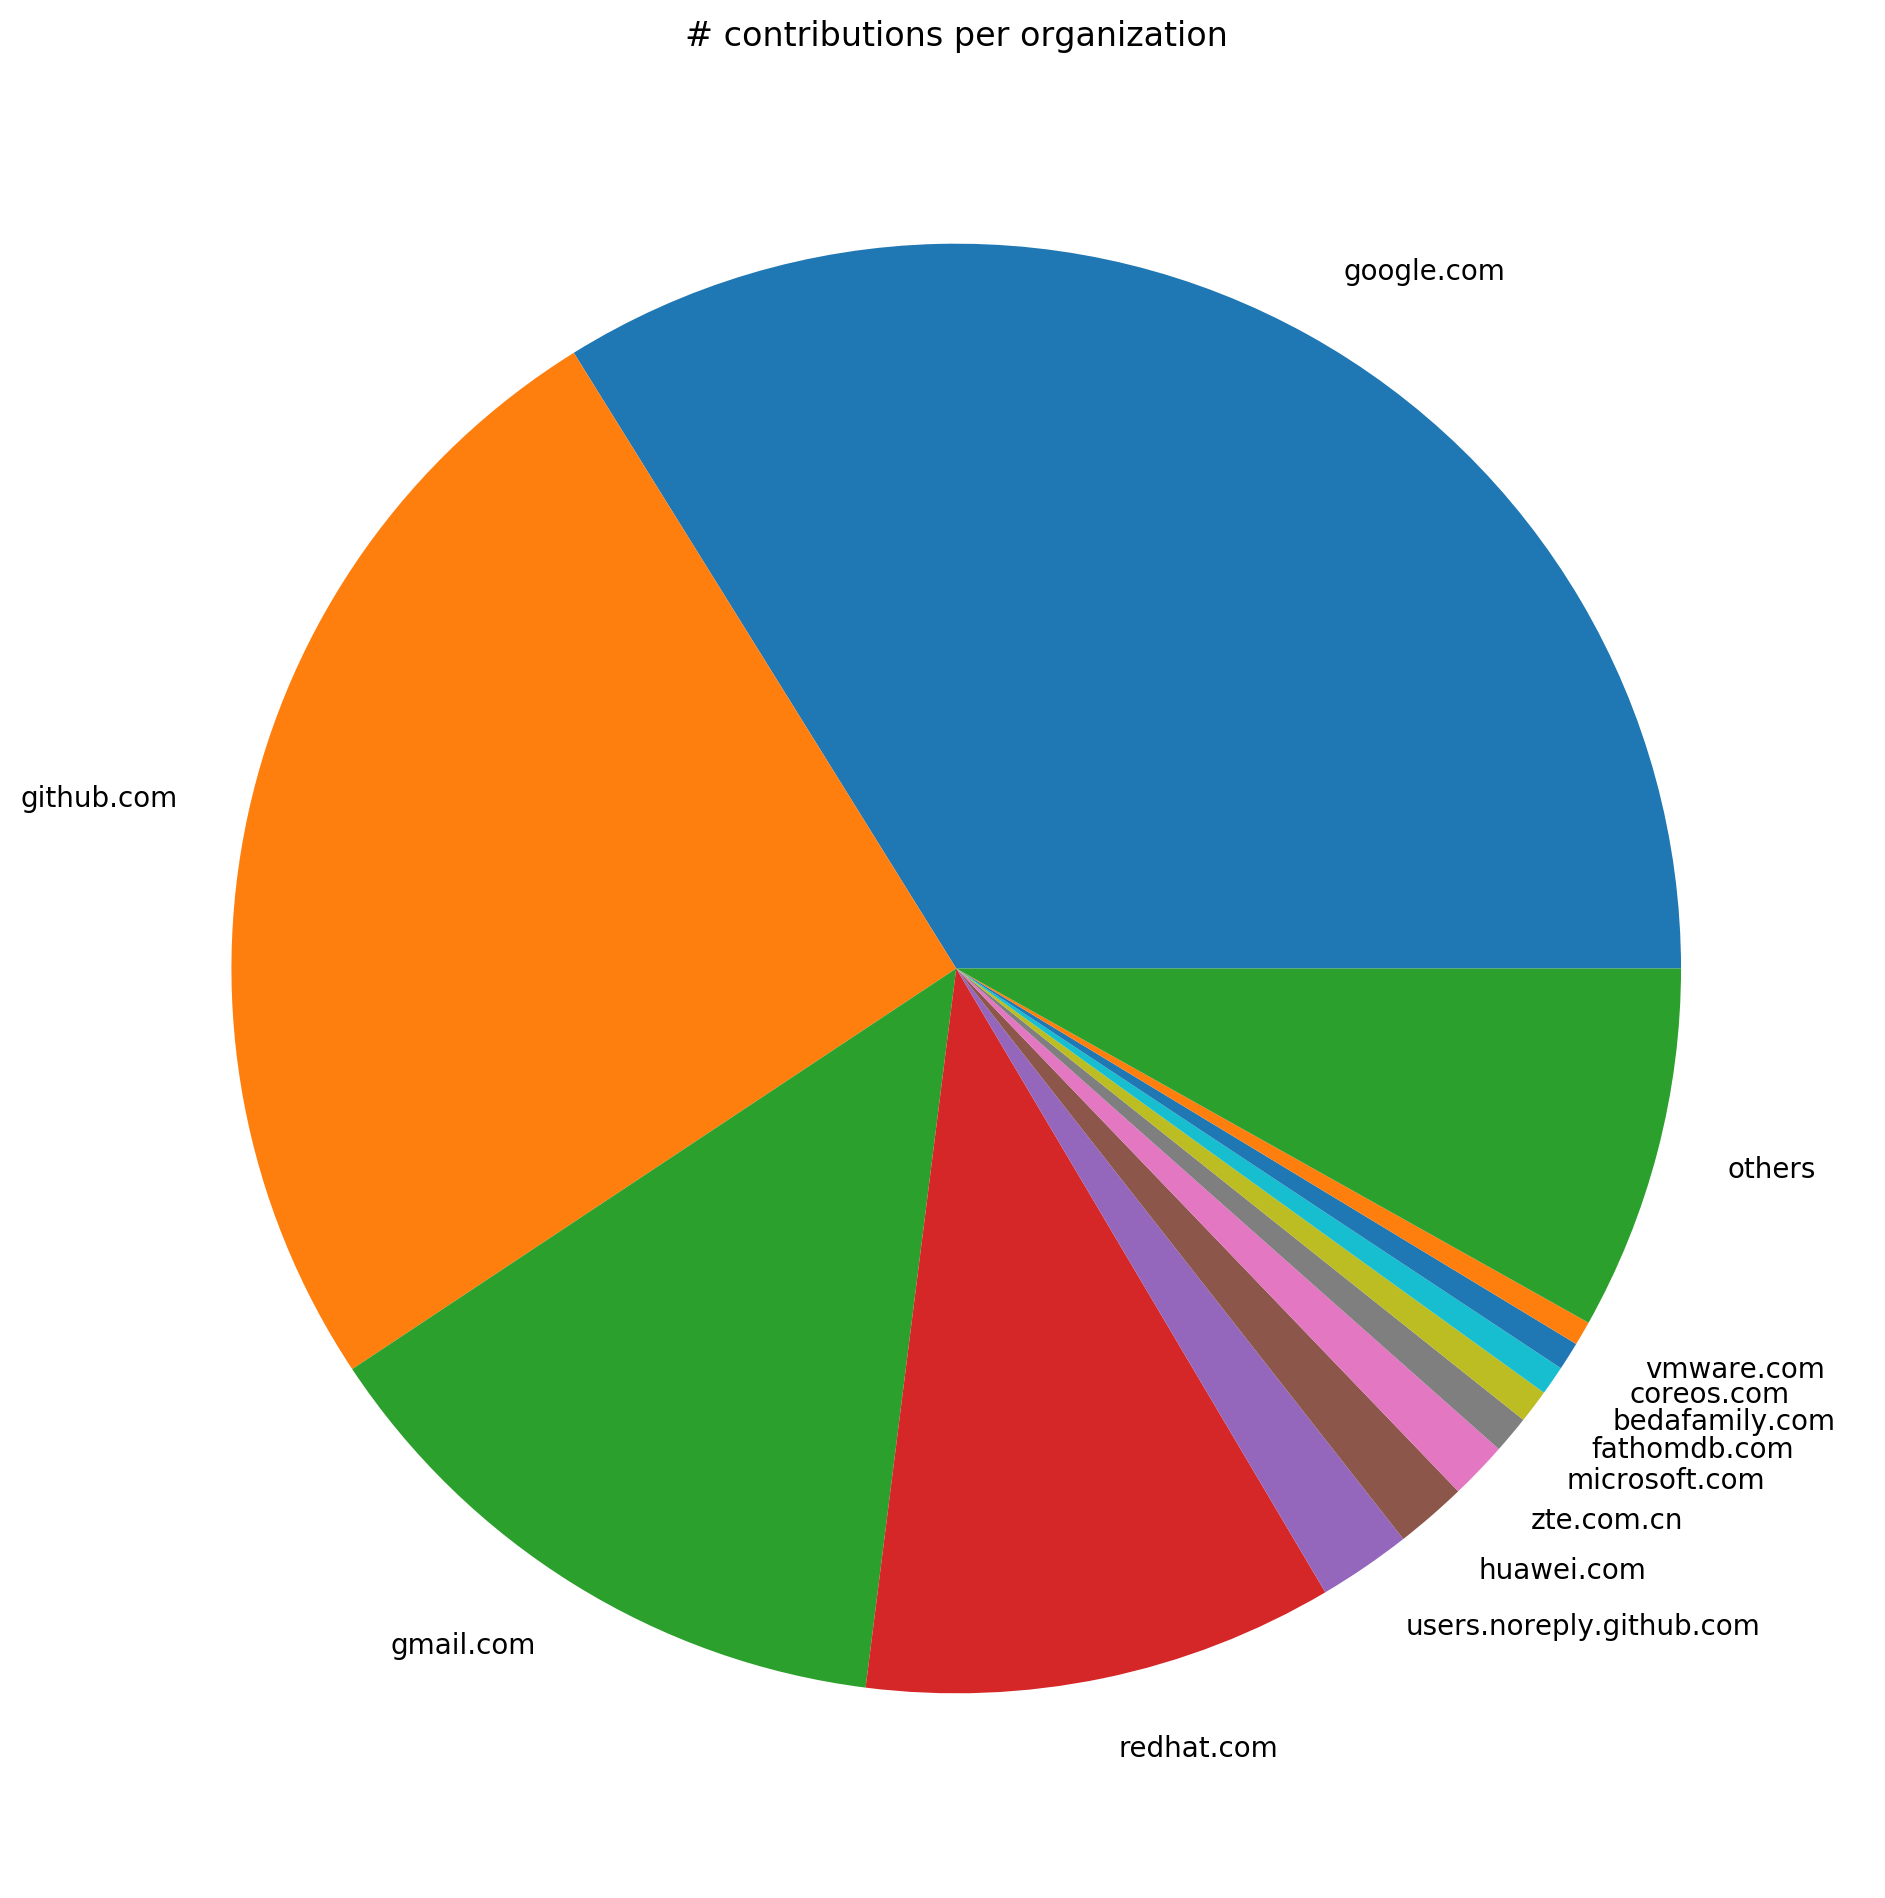

In [291]:
percents = [(100*c)/sum(counts) for c in counts if c/sum(counts) > 0.005]
if len(percents) < len(orgs):
    percents.append(100 - sum(percents))
    labels = orgs[:len(percents)-1] + ['others']
else:
    labels = orgs

plt.figure(figsize=(12, 12), dpi=200)
plt.title('# contributions per organization')
plt.pie(percents, labels=labels)
plt.show()

In [7]:
import ast
from wordcloud import WordCloud
from PIL import Image
from numpy import array

log_counts = np.log(counts)+1
freqs = {org: log_counts[i] for (i, org) in enumerate(orgs)}
mask = array(Image.open("kubernetes.png"))

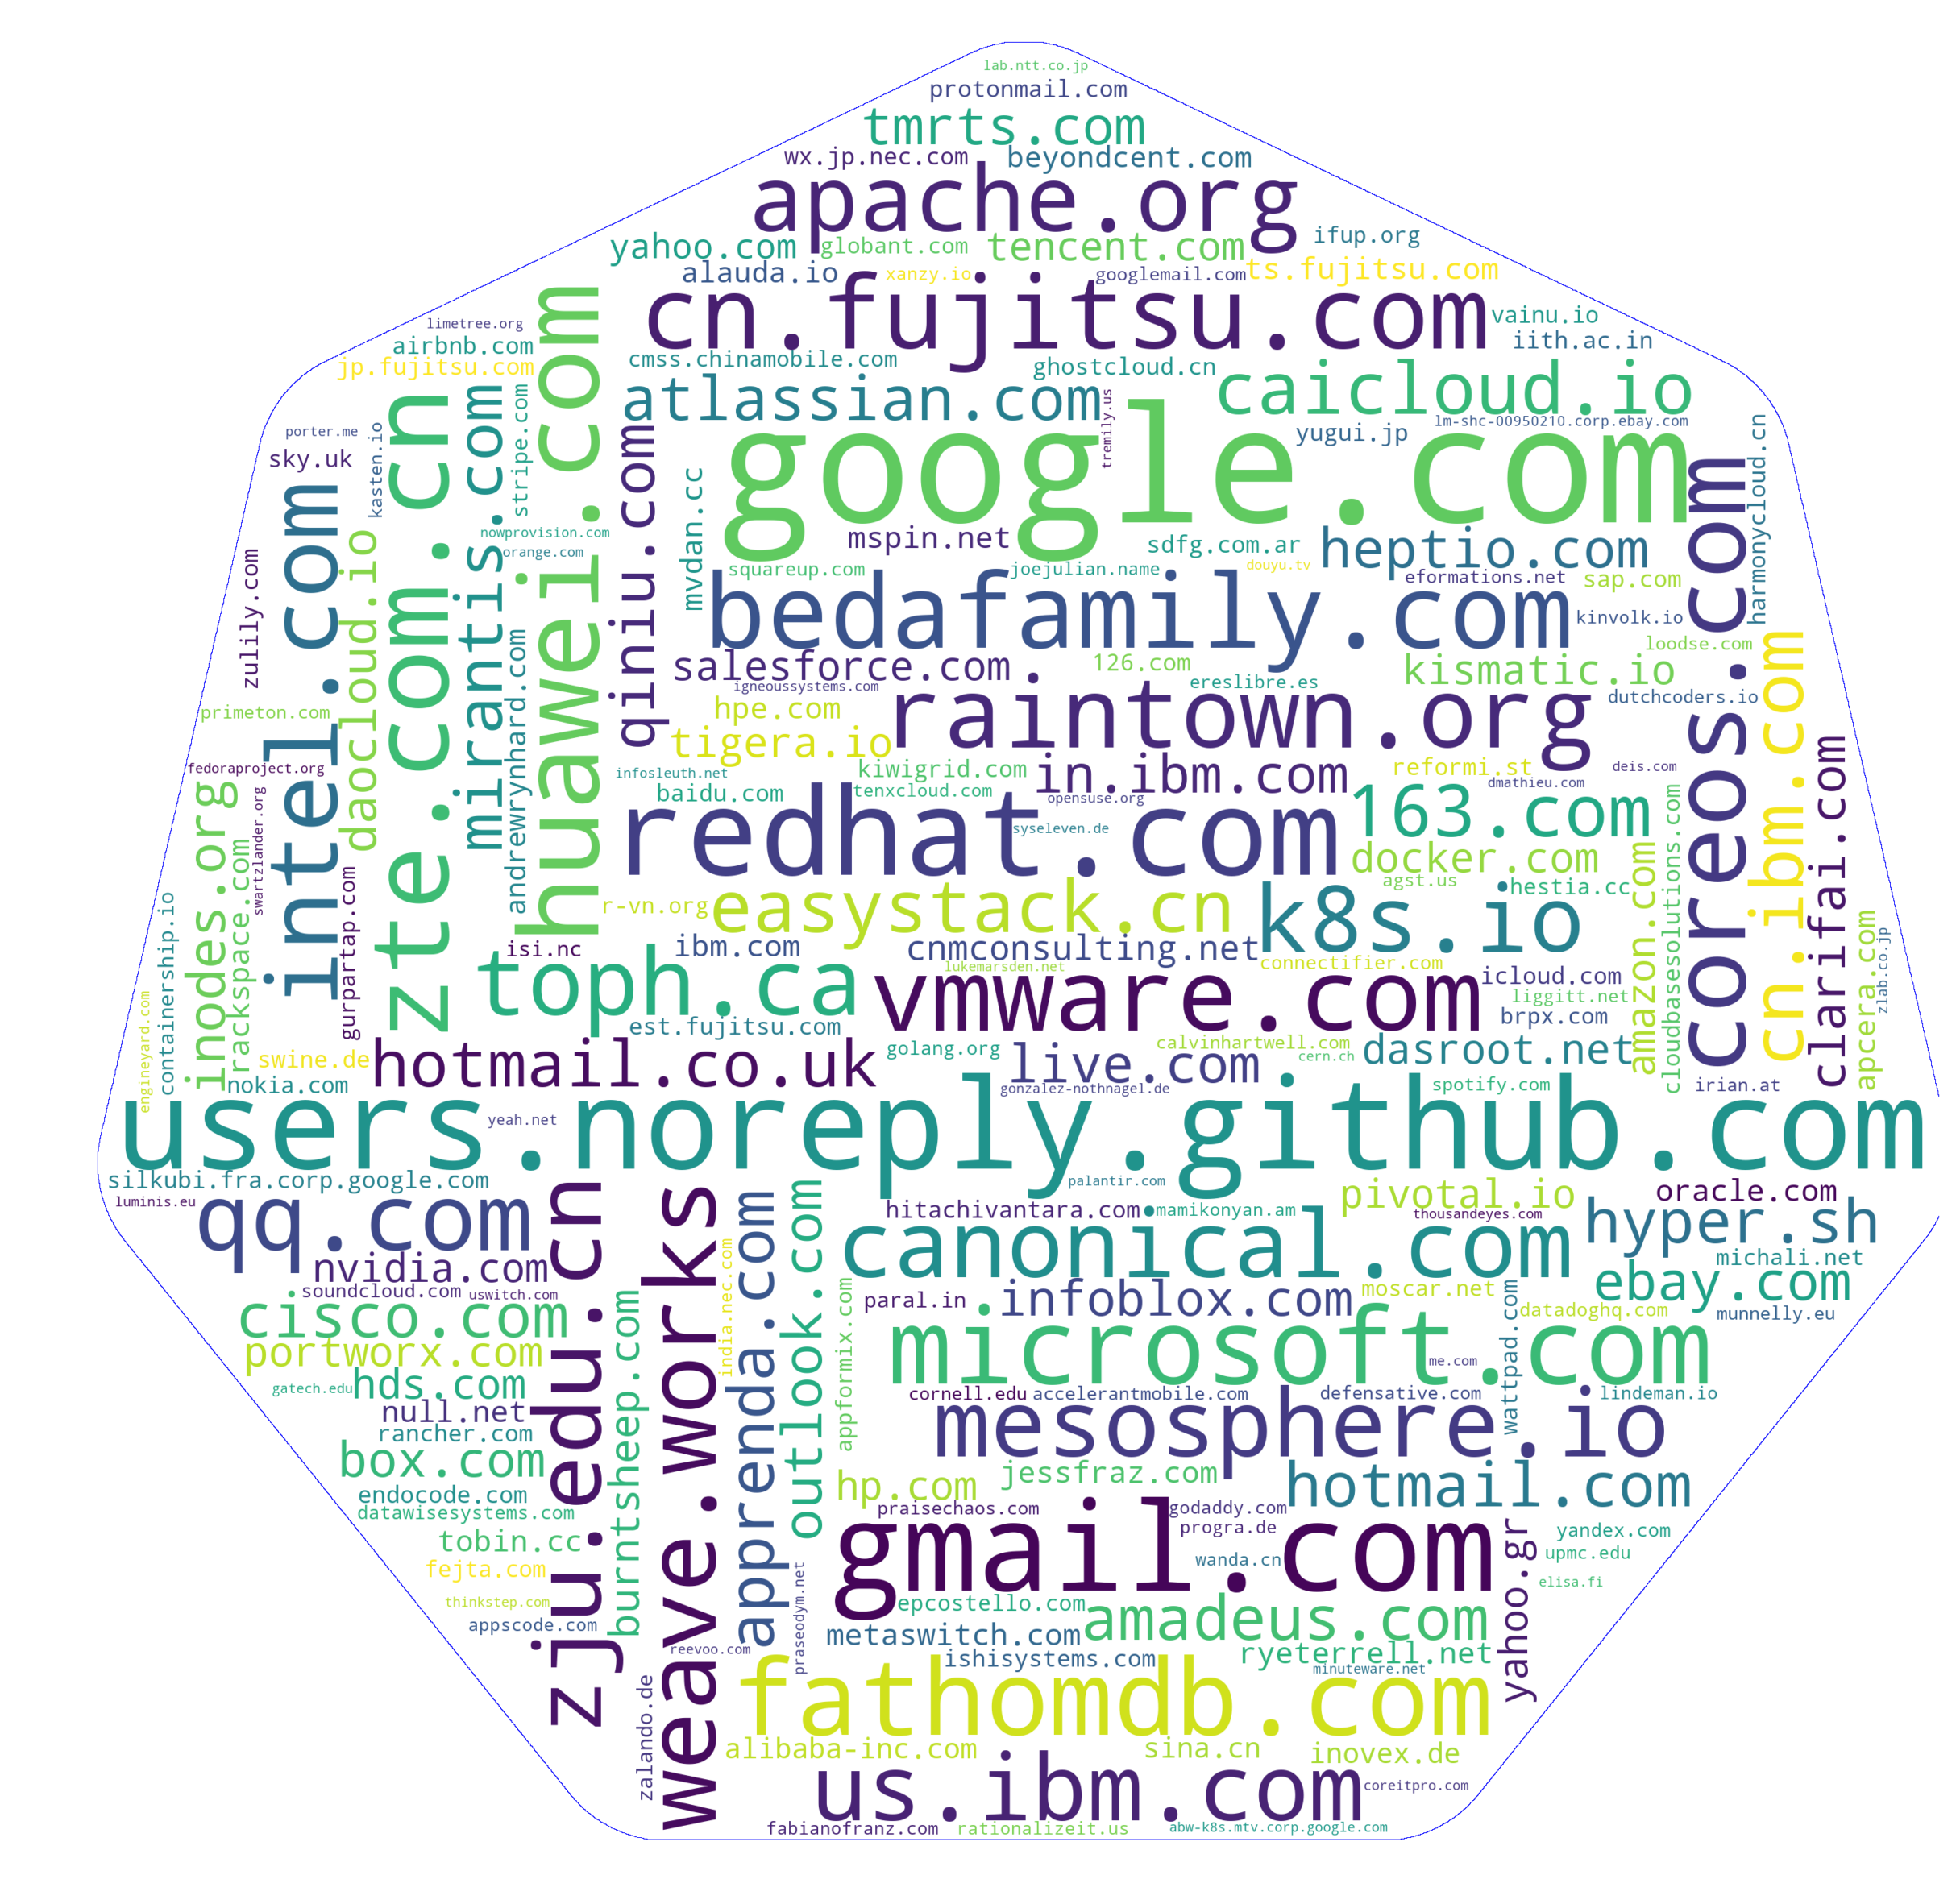

In [294]:
wordcloud = WordCloud(
    width=400,
    height=400,
    background_color='white',
    mask=mask,
    contour_color='blue',
    contour_width=1.0,
    colormap='viridis',
    min_font_size=4
)
wordcloud.generate_from_frequencies(freqs)
plt.figure(figsize=(15,15), dpi=200)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

What organizations have contributed the most to Kubernetes?

In [300]:
(top_contributors, counts) = zip(*run('''
    SELECT committer_email, COUNT(*) as n
    FROM commits
    WHERE repository_id = 'kubernetes'
    GROUP BY committer_email
    ORDER BY n DESC;
'''))

2018-12-06 01:58:50 instance-4 root[5533] INFO done in 15.84 seconds


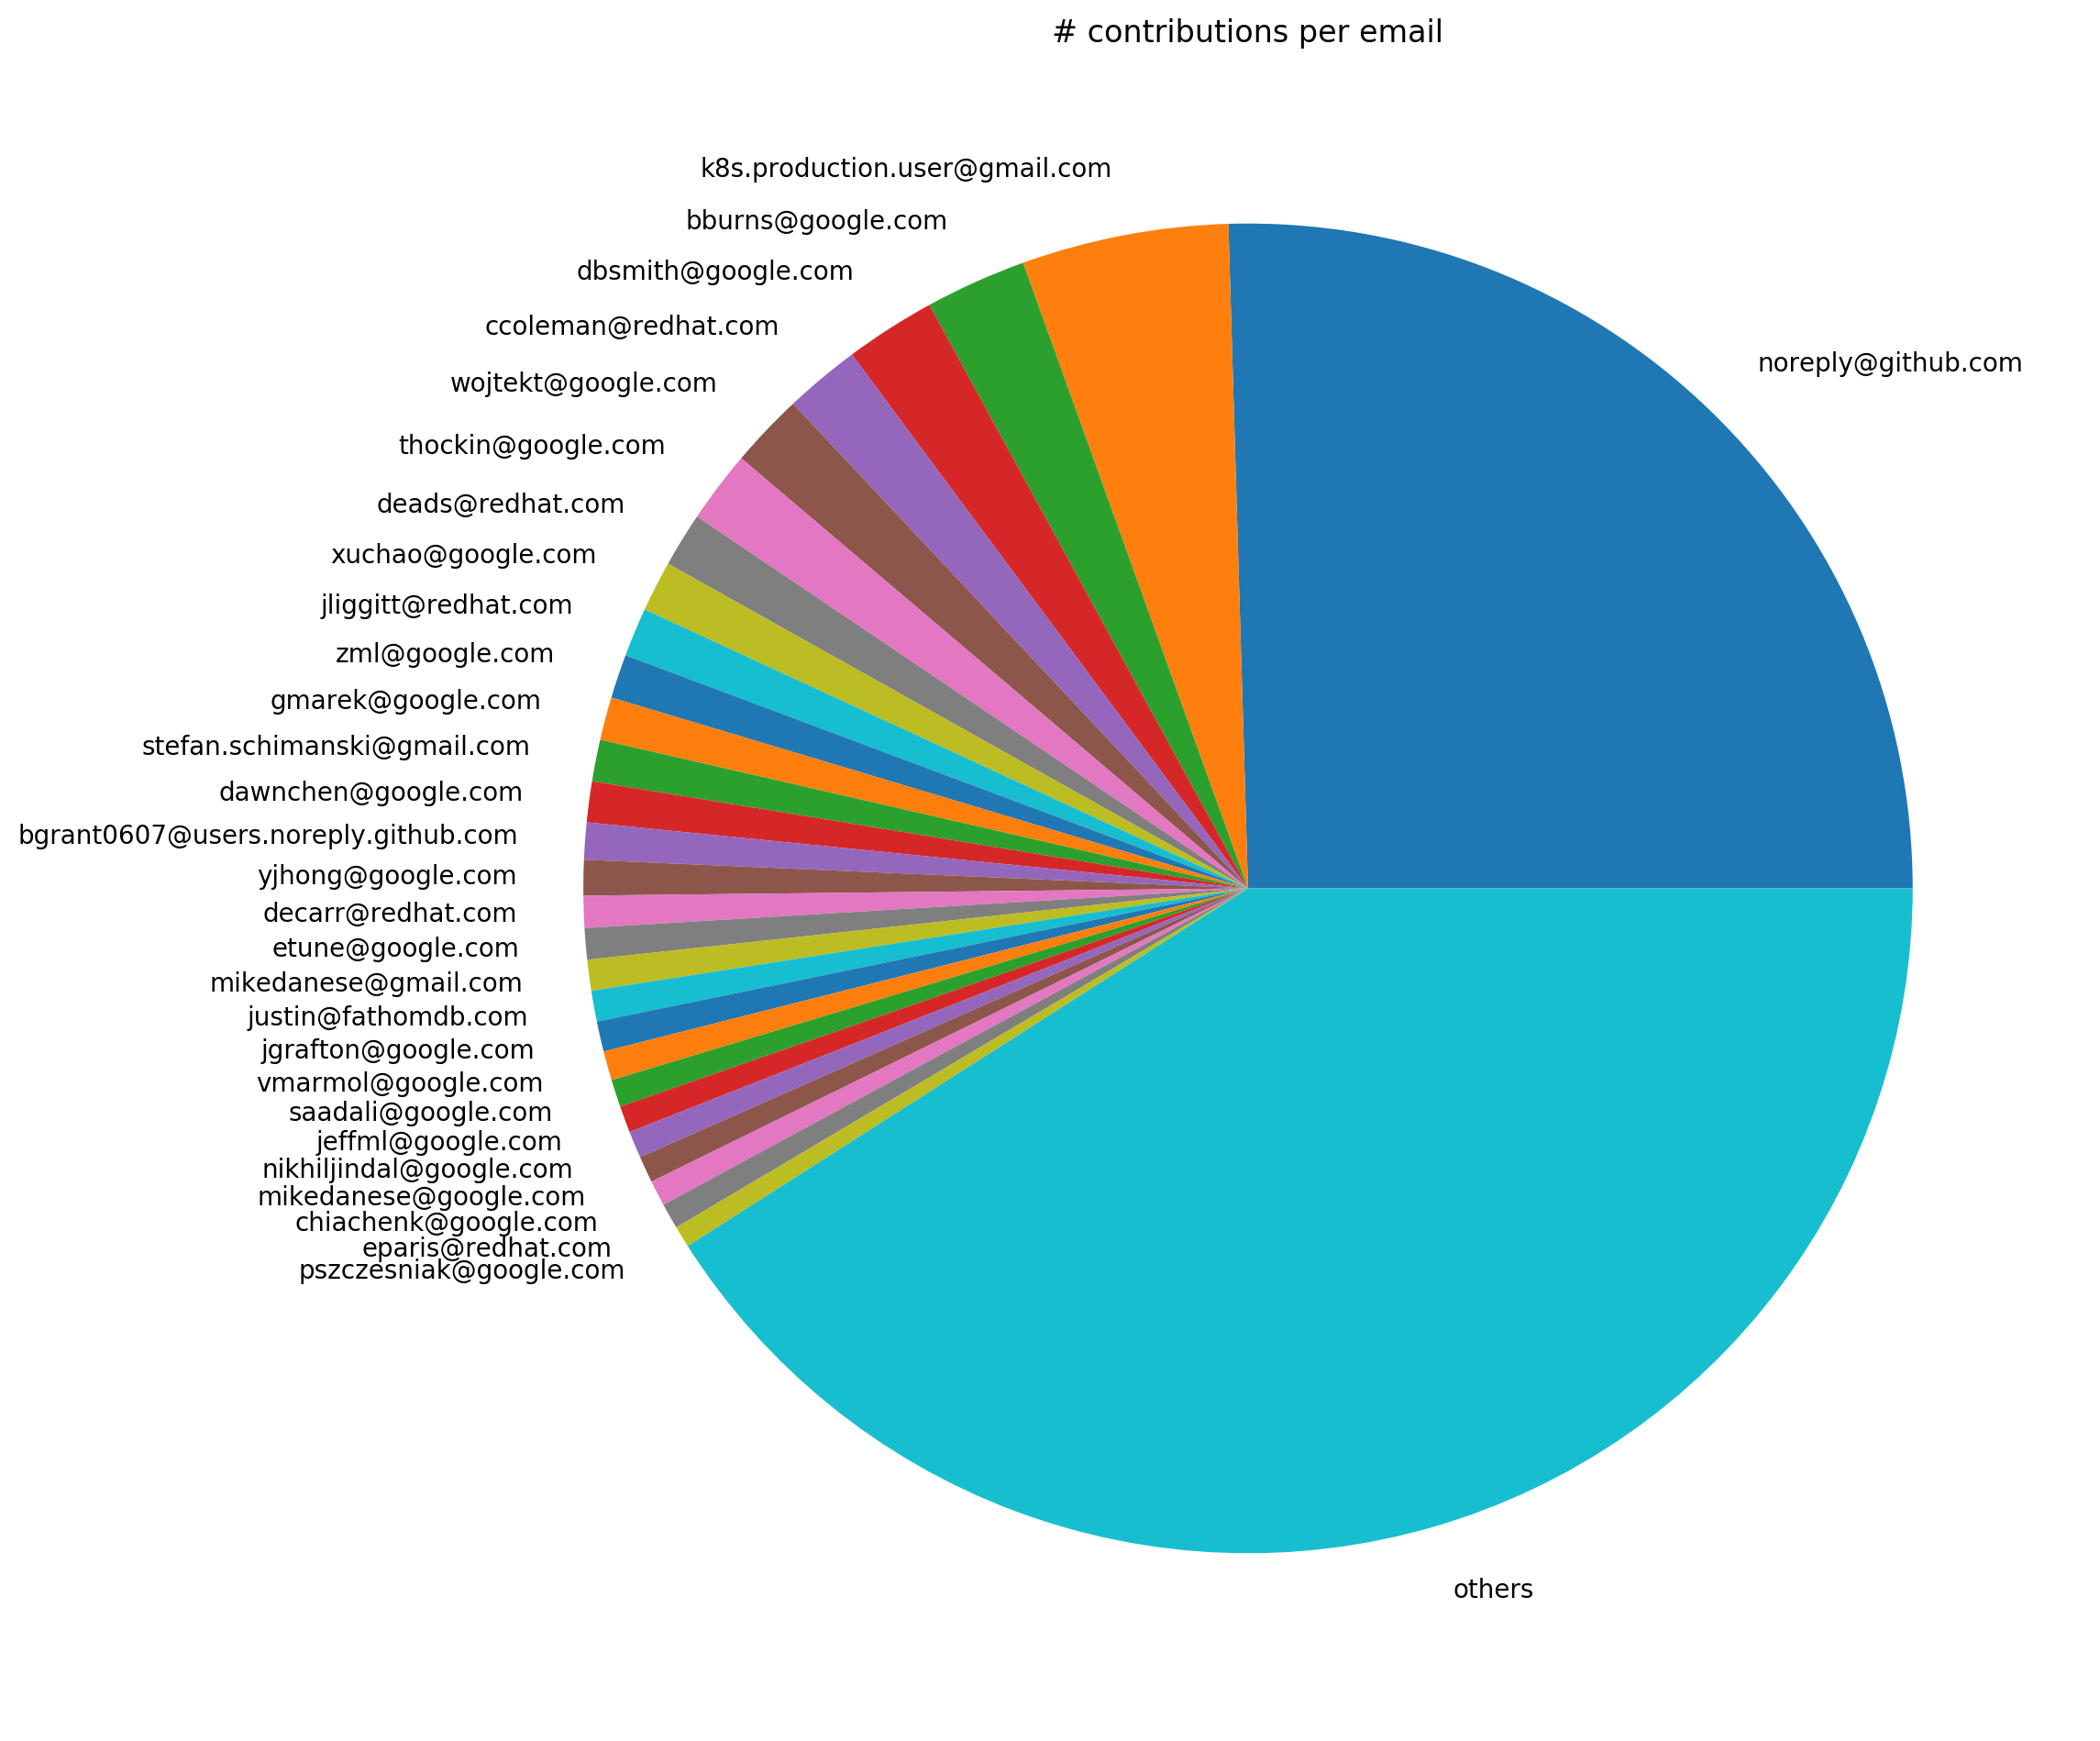

In [306]:
percents = [(100*c)/sum(counts) for c in counts if c/sum(counts) > 0.005]
if len(percents) < len(top_contributors):
    percents.append(100 - sum(percents))
    labels = list(top_contributors[:len(percents)-1]) + ['others']
else:
    labels = top_contributors

plt.figure(figsize=(12, 12), dpi=200)
plt.title('# contributions per email')
plt.pie(percents, labels=labels)
plt.show()

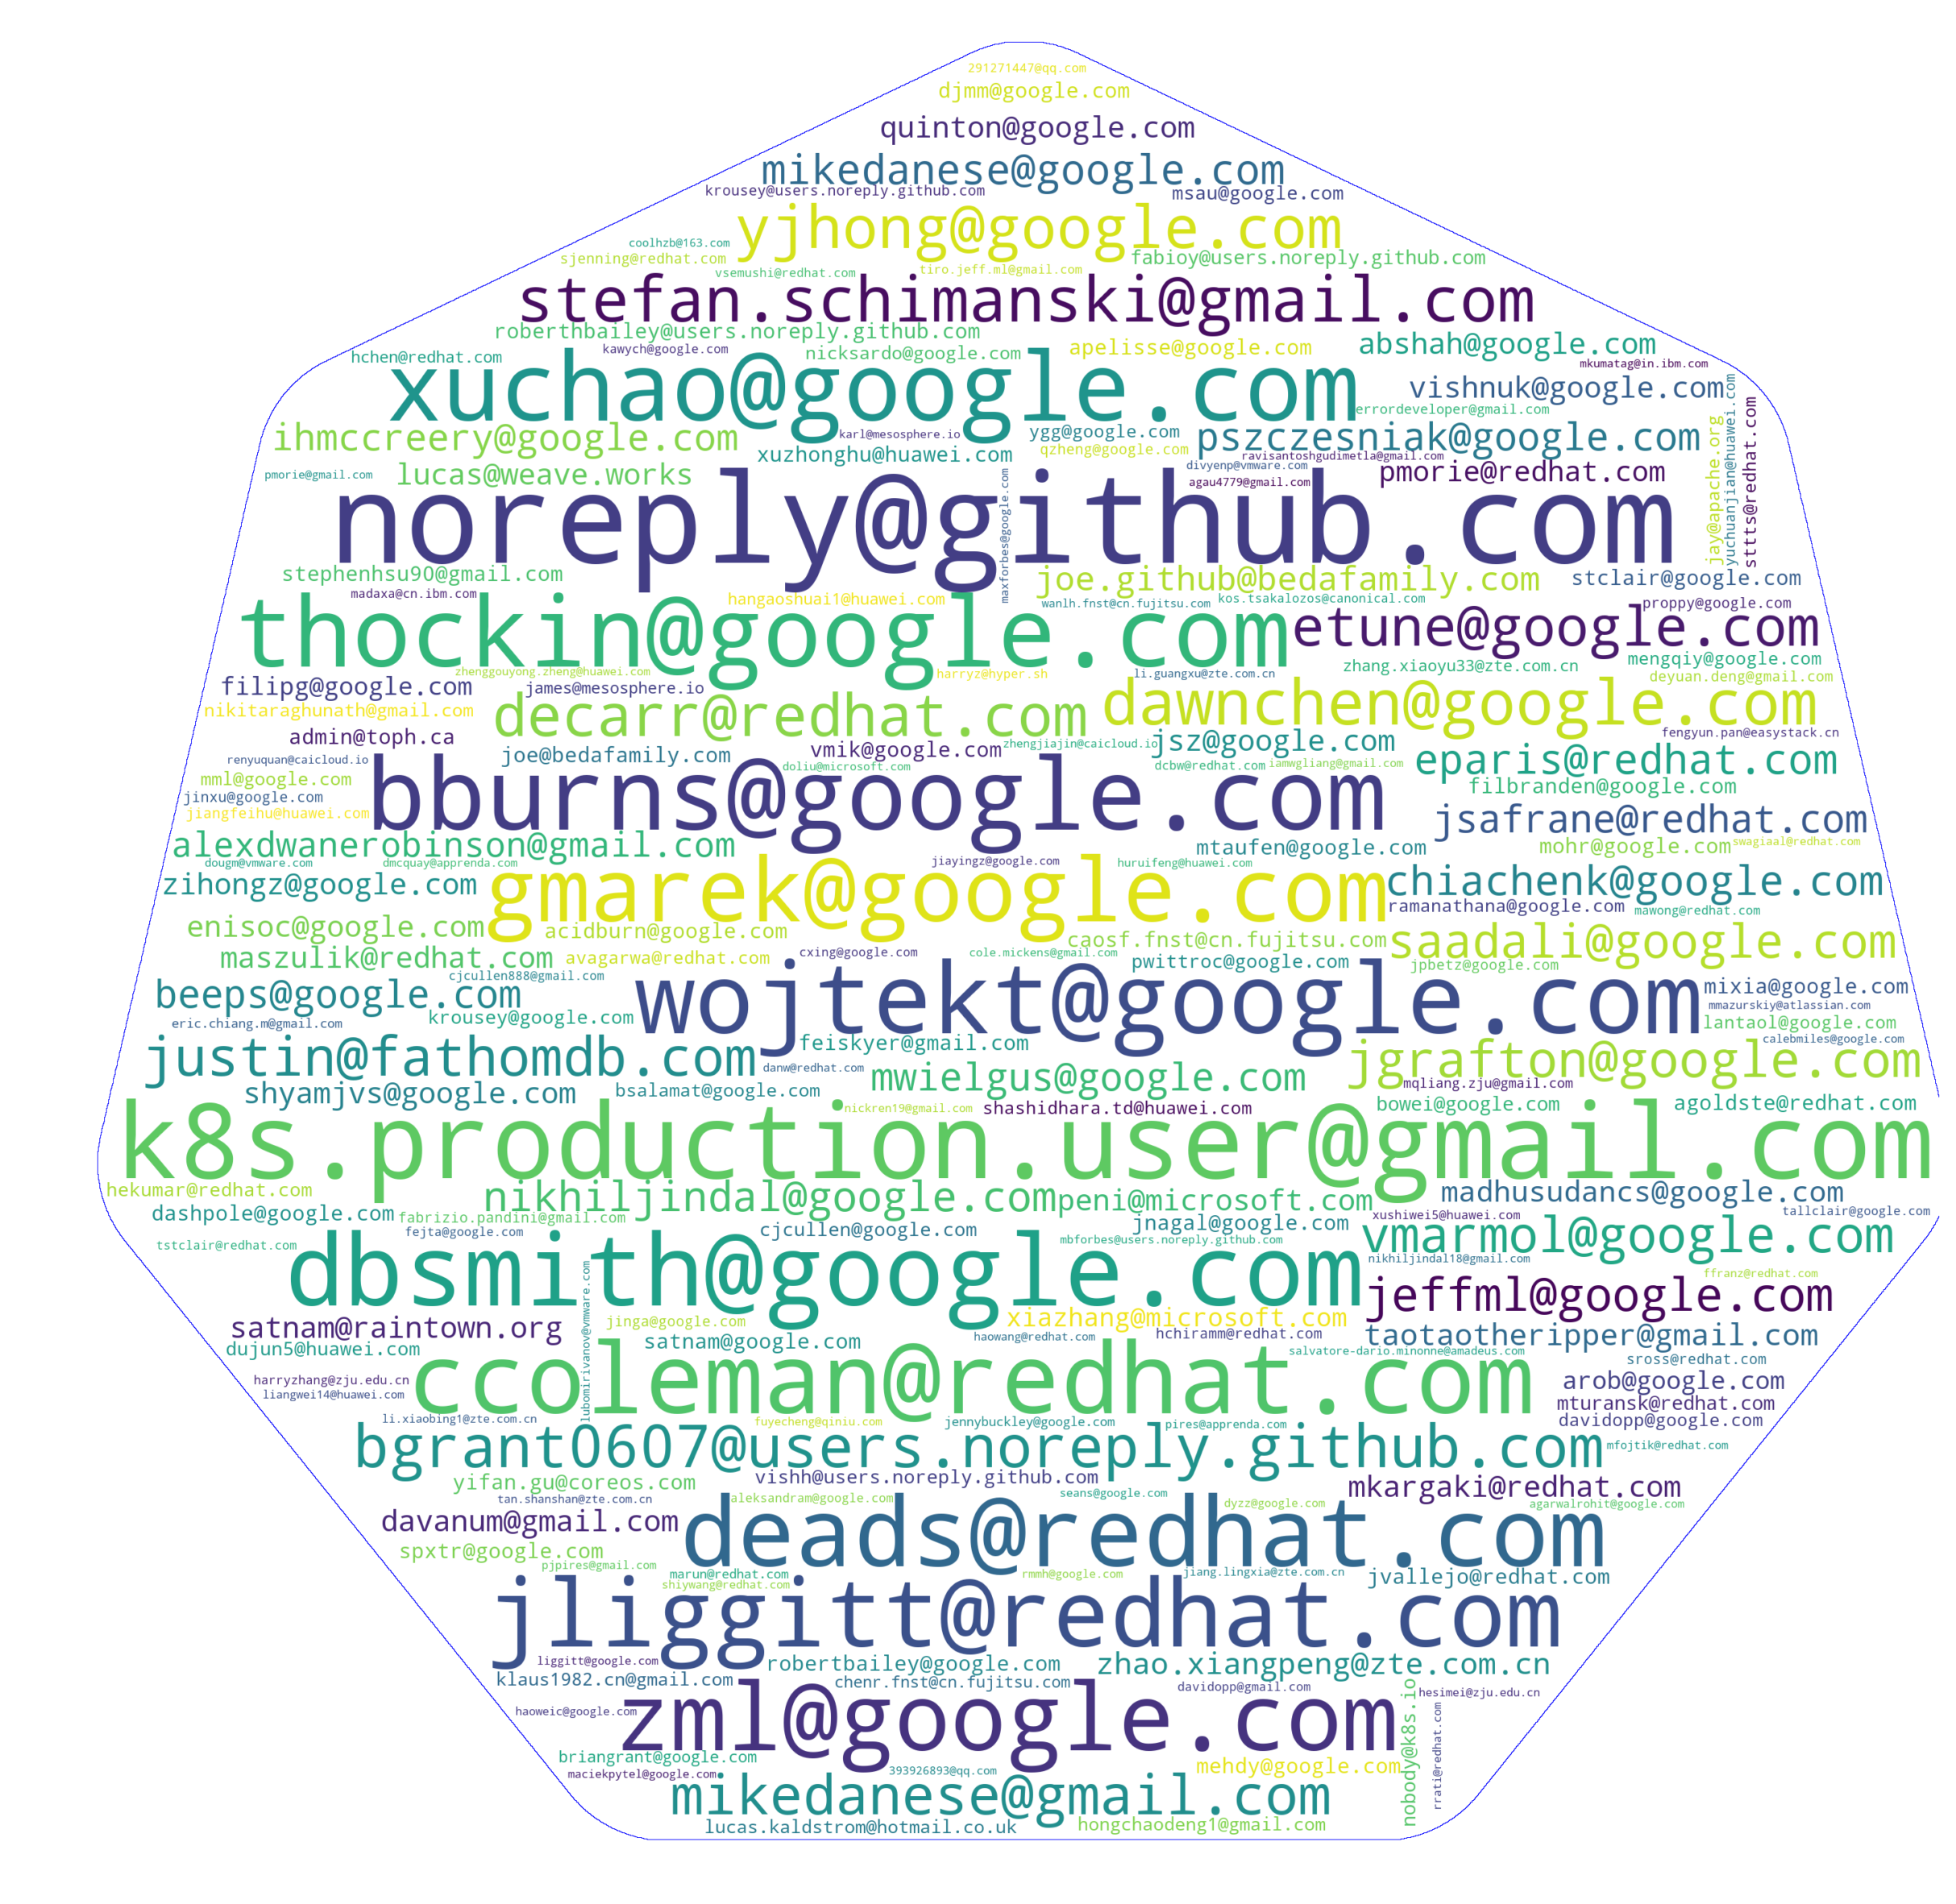

In [301]:
log_counts = np.log(counts)+1
freqs = {email: log_counts[i] for (i, email) in enumerate(top_contributors)}
mask = array(Image.open("kubernetes.png"))

wordcloud = WordCloud(
    width=400,
    height=400,
    background_color='white',
    mask=mask,
    contour_color='blue',
    contour_width=1.0,
    colormap='viridis',
    min_font_size=4
)
wordcloud.generate_from_frequencies(freqs)
plt.figure(figsize=(15,15), dpi=200)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()